Kernel pour le feature engineering : https://github.com/yakupkaplan/Home-Credit-Default-Risk

**Nota : Certaines des cellules ont été complètement été commentées. Il s'agit de celles pour lesquelles les résultats avaient déja été stockés sur Mlflow et qu'on ne voulait plus re-exécuter après avoir relancé le notebook.**

# 1 - Importation des librairies et configuration de l'environnement

In [202]:
import os, sys, time, gc, warnings, operator
from functools import total_ordering, lru_cache
from datetime import datetime
from IPython.core.display import display, HTML
from joblib import dump
import gc
from contextlib import contextmanager
from enum import Enum
import re
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.callbacks import DeltaThreshold, ConsecutiveStopping
from sklearn_genetic.mlflow_log import MLflowConfig
from sklearn_genetic import ExponentialAdapter

import shap

import mlflow

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

In [2]:
# pandas DataFrame column and row display limits
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#for 100% jupyter notebook cell width
display(HTML("<style>.container { width:100% !important; }</style>"))

# random seed for results reproductibility
SEED = 42

# Plots display options
plotly.offline.init_notebook_mode(connected=True)

shap.initjs()

# Load the TensorBoard notebook extension
%load_ext tensorboard

# 2 - Fonctions
## 2.1 - Métriques et tracking des modèles 

On suppose qu'on prête 10€ à chaque client avec un taux d'intérêt de 10%. Les gains associés à chaque prédiction sont donc les suivants :
- pour chaque FN : -10€ (On perd tout le crédit accordé au client)
- pour chaque FP : -1€ (On ne perd que les intérêts)
- pour chaque TN : +1€ (On gagne les intérêts)
- pour chaque TP : 0€ (On ne gagne ni ne perd rien)
    
Ainsi, le gain réalisé par Home Crédit pour N clients est : 
**gain = TN - (10 x FN + FP)**

On en déduit que si le jeu de données contient N clients dont n jugés bons, alors :
- **gain_max = n** (Tous les clients sont correctement identifiés soit n TN et (N-n) TP)
- **gain_min = -10 x (N - n) - n** (Tous les clients sont incorrectement identifiés soit n FP et (N-n) FN)

On veut normaliser ce gain de sorte que :
- f(gain=gain_min) = -1
- f(gain=0) = 0
- f(gain=gain_max) = 1

Notre fonction de gain normalisée est donc égale à :

$$f(gain) = \frac{gain((gain_{min}+gain_{max})gain-(gain_{min}^{2}+gain_{max}^{2}))}{gain_{min}gain_{max}(gain_{max}-gain_{min})}$$

In [3]:
def normalized_business_gain(gain, gain_min, gain_max):
    """
    Normalizes the business gain value
    Args:
        gain (float): the actual gain
        gain_min (float): the lowest gain the model could have predicted
        gain_max (float): the highest gain the model could have predicted
    Returns:
        a float between -1 and 1
    """
    
    if gain_min >= gain_max:
        raise ValueError("The minimum business gain cannot be greater than the maximum business gain")
    if gain < gain_min:
        raise ValueError("The actual business gain cannot be lower than the the minimum business gain")
    if gain > gain_max:
        raise ValueError("The actual business gain cannot be greater than the maximum business gain")
    
    num = gain * ( (gain_min+gain_max)*gain - (gain_min**2+gain_max**2) )
    dem = gain_min*gain_max*(gain_max-gain_min)
    return  num / dem

In [4]:
def business_gain(y, y_pred):
    """
    calculates the maximum business gain of the model.
    Args:
        y (ndarray shape(n_samples,)): ground truth labels
        y_pred (ndarray shape(n_samples, n_classes)): predicted probabilities 
                                                      of classes 0 and 1
    Returns:
        max_gain_score (float)
    """
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
        
    n = len(y[y==0]) # Nomber of good customers
    N = len(y) # Number of customers
    
    # dictionnary to save the business cost for each threshold
    max_gain_score = -1
    
    # for each threshold (precision = 0.01)
    for threshold in np.arange(0.01, 1.0, 0.01):
        
        # labels prediction given the threshold
        cl_pred = np.where(y_pred<threshold, 0, 1)
        
        # calculates true negative, false positive, etc.
        tn, fp, fn, tp = confusion_matrix(y, cl_pred).ravel()
        
        # Calculates the normalized business gain
        gain_score = normalized_business_gain(tn-(10*fn+fp), -10*(N-n)-n, n)
        
        # setting the new maximal business score
        if gain_score > max_gain_score:
            max_gain_score = gain_score
    
    return max_gain_score
    
business_score = make_scorer(business_gain, needs_proba=True)

In [5]:
def threshold_optimum(y, y_pred):
    """
    calculates the threshold with which the business gain is maximun.
    Args:
        y (ndarray shape(n_samples,)): true labels
        y_pred (ndarray shape(n_samples, n_classes)): predicted probabilities
                                                      of classes 0 and 1
    Returns:
        best_threshold (float): between 0 and 1
    """
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
        
    n = len(y[y==0]) # Nomber of good customers
    N = len(y) # Number of customers
    
    # dictionnary to save the business cost for each threshold
    max_gain_score = -1.01
    
    # for each threshold (precision = 0.01)
    for threshold in np.arange(0.01, 1.0, 0.01):
        
        # labels prediction given the threshold
        cl_pred = np.where(y_pred<threshold, 0, 1)
        
        # calculates true negative, false positive, etc.
        tn, fp, fn, tp = confusion_matrix(y, cl_pred).ravel()
        
        # Calculates the normalized business gain
        gain_score = normalized_business_gain(tn-(10*fn+fp), -10*(N-n)-n, n)
        
        # setting the new best threshold
        if gain_score > max_gain_score:
            best_threshold = threshold
            max_gain_score = gain_score
    
    return best_threshold

best_threshold = make_scorer(threshold_optimum, needs_proba=True)

In [6]:
def custom_f1(y, y_pred):
    """
    calculates the F1 score with which the business gain is max.
    Args:
        y (ndarray shape(n_samples,)): ground truth labels
        y_pred (ndarray shape(n_samples, n_classes)): predicted probabilities 
                                                      of classes 0 and 1
    Returns:
        f1_score (float)
    """
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
        
    n = len(y[y==0]) # Nomber of good customers
    N = len(y) # Number of customers
    
    # dictionnary to save the business cost for each threshold
    max_gain_score = -1
    
    # for each threshold (precision = 0.01)
    for threshold in np.arange(0.01, 1.0, 0.01):
        
        # labels prediction given the threshold
        cl_pred = np.where(y_pred<threshold, 0, 1)
        
        # calculates true negative, false positive, etc.
        tn, fp, fn, tp = confusion_matrix(y, cl_pred).ravel()
        
        # Precision
        if tp + fp == 0:
            prec = 0
        else:
            prec = tp / (tp+fp)
        
        # Recall
        if tp + fn == 0:
            rec = 0
        else:
            rec = tp / (tp+fn)
        
        # Calculates the f1 score for this threshold
        if prec + rec == 0:
            f1 = 0
        else:
            f1 = 2*prec*rec / (prec+rec)
        
        # Calculates the normalized business gain
        gain_score = normalized_business_gain(tn-(10*fn+fp), -10*(N-n)-n, n)
        
        # setting the new value of f1_score
        if gain_score > max_gain_score:
            f1_score = f1
            max_gain_score = gain_score        
    
    return f1_score
    
business_f1_score = make_scorer(custom_f1, needs_proba=True)

In [7]:
def lgbm_eval_metric(y, y_pred):
    """
    calculates the business cost due to the incorrect predictions of the model 
    implementation. For LightGBM models only.
    Args:
        y (ndarray shape(n,)): true labels
        y_pred (ndarray shape(n,)): predicted probabilities of class 1
    Returns:
        name of the evaluation metric (string),
        business gain of the model (float),
        Boolean : if True, then the higher the metric, better is the model
    """
    
    return "business_score", business_gain(y, y_pred), True

In [8]:
def neg_business_score(y_pred, dtrain):
    """
    calculates the business cost due to the incorrect predictions of the model 
    implementation. For XGBoost models only.
    Args:
        y_pred (ndarray shape(n,)): predicted probabilities of class 1
        dtrain (xgb.DMatrix shape(n,)): true labels
    Returns:
        name of the evaluation metric (string),
        Negative business gain of the model (float)
    """
    y = dtrain.get_label()
    
    return "neg_business_score", -business_gain(y, y_pred)

In [9]:
def eval_metrics(y, y_pred, threshold):
    """
    calculates different metrics
    Args:
        y (ndarray shape(n_samples,)): Ground truth labels
        y_pred (ndarray shape(n_samples, n_classes)): 
            predicted probabilities of classes 0 and 1
        threshold (float): the threshold probability above which the 
                           predicted label is 1. Must be between 0 and 1.
    Returns:
        - precision score,
        - recall score,
        - f1 score,
        - roc auc score,
        - business gain,
    """
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
        
    n = len(y[y==0]) # Nomber of good customers
    N = len(y) # Number of customers
    
    if threshold < 0 or threshold > 1:
        raise ValueError("The threshold must be between 0 and 1")
    
    # labels prediction given the threshold
    cl_pred = np.where(y_pred<threshold, 0, 1)
    
    # Calculates the metrics
    precision = precision_score(y, cl_pred)
    recall = recall_score(y, cl_pred)
    f1 = f1_score(y, cl_pred)
    accuracy = accuracy_score(y, cl_pred)
    auc = roc_auc_score(y, y_pred)
    
    # normalized business gain
    tn, fp, fn, tp = confusion_matrix(y, cl_pred).ravel()
    gain_metier = normalized_business_gain(tn-(10*fn+fp), -10*(N-n)-n, n)

    return precision, recall, f1, accuracy, auc, gain_metier

In [10]:
def print_metrics(metrics):
    """
    Prints the results of the eval_metrics call
    Args:
        metrics (tuple lenght=6)
    Returns:
        None
    """
    print(f"Business score : {metrics[5]:.3f}")
    print(f"ROC AUC : {metrics[4]:.3f}")
    print(f"F1 score : {metrics[2]:.3f}")
    print(f"Precision : {metrics[0]:.3f}")
    print(f"Recall : {metrics[1]:.3f}")
    print(f"Accuracy : {metrics[3]:.3f}")
    print(81*"-")

In [106]:
def plot_roc_curve(y, y_pred, filename=None):
    """
    Plot the roc curve
    Args:
        y (ndarray shape(n,)): true labels
        y_pred (ndarray shape(n,)): predicted probabilities of class 1
        filename (str): the name of the file the figure will be saved as.
                        default=None
    Returns:
        fig: the roc curve
    """
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
    
    # ROC AUC score
    roc_auc = roc_auc_score(y, y_pred)
        
    # ROC_curve
    plt.ioff()
    fpr, tpr, _ = roc_curve(y, y_pred)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    ax.plot([0, 1], [0, 1],'r--')
    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # saves the figure in a local file
    if isinstance(filename, str):
        plt.savefig(filename)
    
    return fig

In [119]:
def plot_confusion_matrix(y, y_pred, threshold, filename=None):
    """
    Plot the confusion matrix
    Args:
        y (ndarray shape(n,)): true labels
        y_pred (ndarray shape(n,)): predicted probabilities of class 1
        threshold (float): the threshold probability above which the predicted 
                           label is 1. Must be between 0 and 1.
        filename (str): the name of the file the figure will be saved as.
                        default=None
    Returns:
        fig: the confusion_matrix
    """
    if threshold < 0 or threshold > 1:
        raise ValueError("The threshold must be between 0 and 1")
    
    # if array is 2D, probabilities of class 1 are in the 2nd column
    if len(y_pred.shape) > 1:
        y_pred = y_pred[:, 1] # Probability of class 1
    
    # labels prediction given the threshold
    cl_pred = np.where(y_pred<threshold, 0, 1)
    
    # Confusion matrix plot
    plt.ioff()
    cm = confusion_matrix(y, cl_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, colorbar=False, values_format=".0f")
    
    # saves the figure in a local file
    if isinstance(filename, str):
        plt.savefig(filename)
    
    return fig

In [177]:
class LibraryOptions(Enum):
    """
    Valid options for MLflow library 
    """
    sklearn = "sklearn"
    xgboost = "xgboost"
    lightgbm = "lightgbm"

    
@total_ordering
class MLflow_log:
    """
    Logs each experimentation run in a running instance of MLflow. 
    Contains 4 methods:
        1. init method
        2. create_run method
        3. eq method
        4. lt method
    """
    
    def __init__(self, experiment:str, run_name:str, 
                 library:LibraryOptions, 
                 tracking_uri="http://127.0.0.1:5000", tags=None):
        """
        Args
        -----------
            experiment: str
                Case sensitive name of an experiment to be activated.
            run_name: str
                Name of new run (stored as a mlflow.runName tag).
            library: LibraryOptions
                Library of the model. 
            tracking_uri: str, default="http://127.0.0.1:5000"
                Address of local or remote tracking server.
            tags: dict, default=None
                Dictionary of tag_name: String -> value.        
        Returns
        -----------
            None
        """
        self.experiment = experiment
        self.run_name = run_name
        self.library = library
        self.tracking_uri = tracking_uri
        self.tags = tags
        
        if self.library == "sklearn":
            self.library = mlflow.sklearn
        elif self.library == "xgboost":
            self.library = mlflow.xgboost
        else:
            self.library = mlflow.lightgbm
        
        # Will be updated in every create_run method call
        self.score = None
        self.model_name = None
        self.model = None
        self.previous_runs_id = []
        
        # We set the experiment
        mlflow.set_experiment(self.experiment)
        mlflow.set_tracking_uri(self.tracking_uri)
        
        # Ge get the experiment id
        self.experiment_id = mlflow.get_experiment_by_name(self.experiment)\
                                   .experiment_id
        
        # We save the tags if they exist
        if isinstance(self.tags, dict):
            mlflow.set_tags(self.tags)
        
    def create_run(self, model_name:str, model, x_train, x_test, y_train, 
                   y_test, parameters:dict, threshold:float):
        """
        Args
        -----------
            model_name: str
                Name of the model (Run-relative artifact path)
            model:
                the estimator that is being fitted
            x_train, x_test: ndarray(n_samples, n_features)
                resp. the training and testing input features
            y_train, y_test: ndarray(n_samples,)
                Ground truth labels of resp. the training and the testing set
            parameters: dict
                A dictionary with the keys as the hyperparameter name and the 
                value as the current value setting
            threshold: float(between 0.0 and 1.0)
                the threshold probability above which the predicted label is 1
        
        Returns
        -----------
            None
        """
        # Starts a new MLflow run
        with mlflow.start_run(run_name=self.run_name, 
                              experiment_id=self.experiment_id,) as run:
            
            ########## Training and metrics of the model ##########
            # We train the model with the training dataset
            start_time = time.time()
            model.fit(x_train, y_train)
            fit_time = np.round(time.time() - start_time, 2)
            
            # Predictions on the training dataset
            start_time = time.time()
            train_preds = model.predict_proba(x_train)
            train_pred_time = np.round(time.time() - start_time, 2)
            
            # Predictions on the testing dataset
            start_time = time.time()
            test_preds = model.predict_proba(x_test)
            test_pred_time = np.round(time.time() - start_time, 2)
            
            # Metrics of the training dataset
            train_prec, train_rec, train_f1, train_acc, train_auc, train_gc =\
                eval_metrics(y_train, train_preds, threshold)
            
            # Metrics of the testing dataset
            test_prec, test_rec, test_f1, test_acc, test_auc, test_gc =\
                eval_metrics(y_test, test_preds, threshold)
            
            # ROC curve of the training dataset
            train_roc_curve = plot_roc_curve(y_train, train_preds, 
                                             "train_roc_curve.png")
            
            # ROC curve of the training dataset
            test_roc_curve = plot_roc_curve(y_test, test_preds, 
                                            "test_roc_curve.png")
            
            # Confusion matrix of the training dataset
            train_conf_mat = plot_confusion_matrix(
                y_train, train_preds, threshold, "train_confusion_matrix.png")

            # Confusion matrix of the testing dataset
            test_conf_mat = plot_confusion_matrix(
                y_test, test_preds, threshold, "test_confusion_matrix.png")            

            ########## MLflow logging ##########
            # We save the model
            library = self.library
            library.log_model(model, model_name)
            
            # We save the parameters
            for parameter, value in parameters.items():
                mlflow.log_param(key=parameter, value=value)
                
            # We save the metrics of the model
            mlflow.log_metric("test_business_score", test_gc)
            mlflow.log_metric("train_business_score", train_gc)
            mlflow.log_metric("test_roc_auc_score", test_auc)
            mlflow.log_metric("train_roc_auc_score", train_auc)
            mlflow.log_metric("test_f1_score", test_f1)
            mlflow.log_metric("train_f1_score", train_f1)
            mlflow.log_metric("test_precision_score", test_prec)
            mlflow.log_metric("train_precision_score", train_prec)
            mlflow.log_metric("test_recall_score", test_rec)
            mlflow.log_metric("train_recall_score", train_rec)
            mlflow.log_metric("test_accuracy_score", test_acc)
            mlflow.log_metric("train_accuracy_score", train_acc)
            mlflow.log_metric("fit_time", fit_time)
            mlflow.log_metric("test_prediction_time", test_pred_time)
            mlflow.log_metric("train_prediction_time", train_pred_time)
            
            # log the roc_curve and confusion_matrix plots of the test set
            mlflow.log_figure(test_roc_curve, "test_roc_curve.png")
            mlflow.log_figure(test_conf_mat, "test_confusion_matrix.png")
            
            # log the roc_curve and confusion_matrix plots of the train set
            mlflow.log_figure(train_roc_curve, "train_roc_curve.png")
            mlflow.log_figure(train_conf_mat, "train_confusion_matrix.png")
            
            # Save the tables of test predictions and log them as artifacts
            np.savetxt('test_predictions.csv', test_preds, delimiter=',')
            mlflow.log_artifact("test_predictions.csv")
            
            # Save the tables of train predictions and log them as artifacts
            np.savetxt('train_predictions.csv', train_preds, delimiter=',')
            mlflow.log_artifact("train_predictions.csv") 
            
        ########## Update attributes of the instance ##########
        self.model_name = model_name
        self.model = model
        self.score = test_gc
        self.previous_runs_id.append(run.info.run_id)
        
        # We delete from MLflow the second to last run. This way, we ensure
        # that each instance has one and only one run logged in MLflow.org
        if len(self.previous_runs_id) > 1:
            mlflow.delete_run(self.previous_runs_id[-2])
    
    def __eq__(self, other):
        return self.score == other.score

    def __lt__(self, other):
        return self.score < other.score

In [14]:
def resultize(grid, rank_by:str):
    '''
    prints the result of cross validation
    Args:
        grid : an instanciation of GASearchCV
        rank_by (str): rank the results by this column
    Returns:
        res (DataFrame)
    '''
    
    res = pd.DataFrame(grid.cv_results_)
    cols = [col for col in res.columns if "split" not in col]
    res = res[cols]
    res = res.sort_values(rank_by).reset_index(drop=True)
    
    return res

In [394]:
def log_odds_to_proba(x):
    """ 
    Transforms log odds into probability
    Args:
        x (float or array-like)
    returns:
        a float between 0 and 1
    """
    return np.exp(x) / (1 + np.exp(x))

## 2.2 - Feature engineering

In [15]:
@contextmanager
def timer(title):
    """
    prints the time elapsed to achieve a process
    Args
    -----------
        title : Name of the process being carried on
    """
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time()-t0:.0f}s")

In [16]:
def one_hot_encoder(df, nan_as_category = True):
    """
    One-hot encoding for categorical columns with get_dummies
    Args
    -----------
        df: pd.DataFrame
            the dataframe to transform
        nan_as_category: bool (default=True)
            Wether or not to encode NaN

    Returns
    -----------
        df: a DataFrame
        new_columns: list of the columns added to df
    """
    # List of originnal columns of df
    original_columns = list(df.columns)
    
    # List of all categorical columns
    categorical_columns= [col for col in df.columns if df[col].dtype=='object']
    
    # One-hot-encoding of df
    df = pd.get_dummies(df, columns= categorical_columns, 
                        dummy_na= nan_as_category)
    
    # Columns added to df when one-hot-encoding
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns

In [17]:
def rare_encoder(dataframe, rare_perc):
    """
    Rare encoding function for rare labels. Returns dataframe with 'Rare' 
    encoded labels
    Args
    -----------
        dataframe: dataframe
            dataframe to be rare encoded
        rare_perc: float
            percentage for lables to be accepted as 'Rare'
    Returns
    -----------
        dataframe
    """
    temp_df = dataframe.copy()
    
    # Select categorical columns where there is at least one category with a
    # frequency lower than rare_perc
    rare_columns = \
        [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and\
        (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    
    for var in rare_columns:
        
        # frequency of each category in var
        tmp = temp_df[var].value_counts() / len(temp_df)
        
        # select only the categories whose frequency is lower than rare_perc
        rare_labels = tmp[tmp < rare_perc].index
        
        # replace the value of these categories by 'Rare'
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', 
                                temp_df[var])
        
    return temp_df

In [18]:
def application_train_preprocess(directory="../input/",
                                 file_name = "application_train.csv",
                                 fill_na=False):
    """
    Feature Engineering steps for application_train. 
    Returns dataframe with FE steps implemented.
    Args
    -----------
        directory: str (default = "../input/")
            directory where the datasets are stored
        file_name: str (default = "application_train.csv")
            name of the file to load
        fill_na: bool (default = False)
            wether or not to fill missing values
    Returns
    -----------
        dataframe
    """
    file_path = directory + file_name
    df = pd.read_csv(file_path)
    
    # Remove applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Remove applications with Unknown NAME_FAMILY_STATUS
    df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Missing values
    if fill_na:
        df["OCCUPATION_TYPE"].fillna(value="Other", inplace=True)
        df["OWN_CAR_AGE"].fillna(value= df["DAYS_BIRTH"] / -365, 
                                 inplace=True)
        df["EXT_SOURCE_1"].fillna(value=0.5, inplace=True)
        df["EXT_SOURCE_3"].fillna(value=0.5, inplace=True)
        df["DAYS_EMPLOYED"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_HOUR"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_DAY"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_WEEK"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_MON"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(value=0, inplace=True)
        df["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(value=0, inplace=True)
        df["NAME_TYPE_SUITE"].fillna(value="Unaccompanied", inplace=True)
        df["OBS_30_CNT_SOCIAL_CIRCLE"].fillna(value=0, inplace=True)
        df["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(value=0, inplace=True)
        df["EXT_SOURCE_2"].fillna(value=0.5, inplace=True)
        df['DAYS_LAST_PHONE_CHANGE'].fillna(value=0, inplace=True)
        df["AMT_GOODS_PRICE"].fillna(value=0.90614*df["AMT_CREDIT"]-4889, 
                                     inplace=True)
        df["AMT_ANNUITY"].fillna(value= 0.027732 * df["AMT_CREDIT"]+10495, 
                                 inplace=True)
    
    # Some simple new features (percentages and flags)
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON']= df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_INCOME_PER_PERSON_PERC_AMT_ANNUITY'] = \
        df['NEW_INCOME_PER_PERSON'] / df['AMT_ANNUITY']
    df['NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON'] = \
        df['NEW_INCOME_PER_PERSON'] / df['NEW_PAYMENT_RATE']
    df.loc[(df['AMT_CREDIT'] <= df['AMT_GOODS_PRICE']), 
           'NEW_FLAG_CREDIT_MORE_THAN_GOODSPRICE'] = 0
    df.loc[(df['AMT_CREDIT'] > df['AMT_GOODS_PRICE']), 
           'NEW_FLAG_CREDIT_MORE_THAN_GOODSPRICE'] = 1
    df['NEW_AGE_RANGE'] = pd.cut(x=df['DAYS_BIRTH'] / -365, 
                                 bins=[-0.001, 20, 30, 40, 50, 65, 99], 
                                 labels=[1, 2, 3, 4, 5, 6])
    df['NEW_WORKING_YEAR_RANGE'] = pd.cut(x=df['DAYS_EMPLOYED'] / -365, 
                                          bins=[-0.001, 3, 5, 15, 50], 
                                          labels=[1, 2, 3, 4])
    df["NEW_TOTAL_CONTACT_INFORMATION"] = \
        df['FLAG_MOBIL'] + df['FLAG_EMP_PHONE'] + df['FLAG_WORK_PHONE'] +\
        df['FLAG_CONT_MOBILE'] + df['FLAG_EMAIL']
    df['NEW_YEAR_LAST_PHONE_CHANGE'] = \
        pd.cut(x=df['DAYS_LAST_PHONE_CHANGE'] / -365,
               bins=[-0.1, 0, 1, 2, 3, 4, 5, 12], 
               labels=[0, 1, 2, 3, 4, 5, 6]) 
    df["NEW_MISS_DOCUMENTS_20"] = \
        df[['FLAG_DOCUMENT_'+str(i) for i in range(2,22)]].sum(axis=1)
    df['NEW_FLAG_MISS_DOCUMENTS'] = \
        df['NEW_MISS_DOCUMENTS_20'].apply(lambda x: 1 if x > 0 else 0)
    df["NEW_AMT_REQ_CREDIT_BUREAU_YEAR"] = \
        df["AMT_REQ_CREDIT_BUREAU_HOUR"] + df["AMT_REQ_CREDIT_BUREAU_DAY"] +\
        df["AMT_REQ_CREDIT_BUREAU_WEEK"] + df["AMT_REQ_CREDIT_BUREAU_MON"] +\
        df["AMT_REQ_CREDIT_BUREAU_QRT"] + df["AMT_REQ_CREDIT_BUREAU_YEAR"]
    df.loc[(df["NEW_AMT_REQ_CREDIT_BUREAU_YEAR"] >= 7), 
           "NEW_AMT_REQ_CREDIT_BUREAU_YEAR"] = 7

    # Define the list of variables to drop.
        # List of variables that we deem of no interest with the prediction
    drop_list = ['FLAG_DOCUMENT_9', 'LANDAREA_MODE', 'FLAG_WORK_PHONE', 
                 'FLAG_DOCUMENT_8', 'FLOORSMIN_MEDI', 'ELEVATORS_MODE', 
                 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
                 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_19', 
                 'AMT_REQ_CREDIT_BUREAU_MON', 'NONLIVINGAPARTMENTS_MEDI',
                 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_16', 
                 'ENTRANCES_MODE', 'CNT_FAM_MEMBERS', 'ENTRANCES_MEDI', 
                 'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 
                 'FLAG_DOCUMENT_7', 'FLOORSMAX_AVG', 'FLAG_DOCUMENT_18', 
                 'AMT_REQ_CREDIT_BUREAU_HOUR', 'LIVINGAPARTMENTS_MODE',
                 'FLAG_DOCUMENT_2', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 
                 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_10', 'ELEVATORS_AVG', 
                 'YEARS_BUILD_MODE', 'COMMONAREA_AVG', 
                 'AMT_REQ_CREDIT_BUREAU_DAY', 'LIVINGAREA_MODE',
                 'FLAG_DOCUMENT_3', 'LANDAREA_MEDI', 'DAYS_LAST_PHONE_CHANGE',
                 'REG_REGION_NOT_WORK_REGION', 'COMMONAREA_MEDI', 
                 'YEARS_BEGINEXPLUATATION_MEDI', 'REGION_RATING_CLIENT_W_CITY', 
                 'FLAG_DOCUMENT_5', 'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG',
                 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'NONLIVINGAREA_MEDI', 
                 'FLAG_DOCUMENT_21', 'YEARS_BEGINEXPLUATATION_MODE', 
                 'APARTMENTS_AVG', 'ENTRANCES_AVG', 'FLAG_PHONE',
                 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_6', 
                 'BASEMENTAREA_AVG', 'FLAG_DOCUMENT_14', 'FLAG_EMP_PHONE', 
                 'NONLIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'FLAG_MOBIL', 
                 'LIVINGAREA_AVG', 'FLAG_CONT_MOBILE', 
                 'AMT_REQ_CREDIT_BUREAU_WEEK', 'YEARS_BUILD_AVG', 
                 'NONLIVINGAREA_AVG', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_4', 
                 'AMT_REQ_CREDIT_BUREAU_QRT', 'LIVINGAPARTMENTS_MEDI',
                 'FLAG_DOCUMENT_11', 'NONLIVINGAREA_MODE', 
                 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DEF_60_CNT_SOCIAL_CIRCLE', 
                 'FLAG_DOCUMENT_20', 'FLOORSMIN_MODE', 'FLAG_EMAIL',
                 'OBS_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_MEDI', 'LANDAREA_AVG', 
                 'APARTMENTS_MODE', 'FLAG_DOCUMENT_17', 'LIVINGAREA_MEDI', 
                 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'WALLSMATERIAL_MODE', 
                 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
                 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']
    
        # Let's add to this list variables that are strongly correlated
    drop_list += ["NAME_INCOME_TYPE", "ORGANIZATION_TYPE", "FLAG_EMP_PHONE",
                  "LIVE_REGION_NOT_WORK_REGION", "LIVE_CITY_NOT_WORK_CITY", 
                  "REGION_RATING_CLIENT_W_CITY", "AMT_GOODS_PRICE", 
                  "AMT_ANNUITY", "CNT_FAM_MEMBERS",]
    
    drop_list = list(set(drop_list))
    df.drop(drop_list, axis=1, inplace=True)
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature] = \
            df[bin_feature].apply(lambda x: 0 if (x=="N" or x=="F") else 1)
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df)

    return df

In [19]:
def feature_eng_bureau_and_balance(df):
    """
    Feature Engineering steps for bureau. Returns dataframe with FE steps 
    implemented.
    Args
    -----------
        df: dataframe
                bureau
    Returns
    -----------
        dataframe
    """ 
    # Fill missing values
    df.fillna(0, inplace=True)
    
    # Number of previous loans of the applicant
    grp = df[['SK_ID_CURR', 'DAYS_CREDIT']]\
            .groupby(by=['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index()\
            .rename(index=str, columns={'DAYS_CREDIT':'NEW_BUREAU_LOAN_COUNT'})
    df = df.merge(grp, on=['SK_ID_CURR'], how='left')
    
    # Number of type of loans previously granted to the applicant
    grp = df[['SK_ID_CURR', 'CREDIT_TYPE']]\
            .groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index()\
            .rename(index=str, columns={'CREDIT_TYPE':'NEW_BUREAU_LOAN_TYPES'})
    df = df.merge(grp, on=['SK_ID_CURR'], how='left')
    
    # Percentage of active loans
    df['CREDIT_ACTIVE_BINARY'] = \
        df['CREDIT_ACTIVE'].apply(lambda x: 1 if x == 'Active' else 0)
    grp = df.groupby(by=['SK_ID_CURR'])['CREDIT_ACTIVE_BINARY']\
            .mean().reset_index()\
            .rename(index=str, 
                    columns={'CREDIT_ACTIVE_BINARY': 
                             'NEW_ACTIVE_LOANS_PERCENTAGE'})
    df = df.merge(grp, on=['SK_ID_CURR'], how='left')
    
    # Percentage of CB credits fully paid off
    df['CREDIT_ENDDATE_BINARY'] = \
        df['DAYS_CREDIT_ENDDATE'].apply(lambda x: 0 if x <= 0 else 1)
    grp = df.groupby(by=['SK_ID_CURR'])['CREDIT_ENDDATE_BINARY']\
            .mean().reset_index()\
            .rename(index=str, columns={'CREDIT_ENDDATE_BINARY': 
                                        'NEW_CREDIT_ENDDATE_PERCENTAGE'})
    df = df.merge(grp, on=['SK_ID_CURR'], how='left')
    
    # Total customer credit and total customer debt
    grp1 = df[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']]\
            .groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum()\
            .reset_index().rename(index=str, 
                                  columns={'AMT_CREDIT_SUM_DEBT': 
                                           'TOTAL_CUSTOMER_DEBT'})
    grp2 = df[['SK_ID_CURR', 'AMT_CREDIT_SUM']]\
            .groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum()\
            .reset_index().rename(index=str,columns={'AMT_CREDIT_SUM': 
                                                     'TOTAL_CUSTOMER_CREDIT'})
    df = df.merge(grp1, on=['SK_ID_CURR'], how='left')
    df = df.merge(grp2, on=['SK_ID_CURR'], how='left')
    
    # Ratio debt / credit
    df['NEW_DEBT_CREDIT_RATIO'] = \
        df['TOTAL_CUSTOMER_DEBT'] / df['TOTAL_CUSTOMER_CREDIT']
    mask = (df["NEW_DEBT_CREDIT_RATIO"]==np.inf) |\
           (df["NEW_DEBT_CREDIT_RATIO"]==-np.inf)
    df.loc[mask, "NEW_DEBT_CREDIT_RATIO"] = 0
    
    # Deleting strongly correlated features
    drop_list = ["DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE", 
                 "AMT_CREDIT_SUM_DEBT"]
    # Deleting other useless features
    drop_list += ["CREDIT_ENDDATE_BINARY", "CREDIT_ACTIVE_BINARY", 
                  "TOTAL_CUSTOMER_DEBT", "TOTAL_CUSTOMER_CREDIT"]
    df.drop(drop_list, axis=1, inplace=True)

    return df

In [20]:
def aggregations_bureau_and_balance(bureau, bb, bureau_cat, bb_cat):
    """
    Aggregation operations for bureau_and_balance
    Returns dataframe after completing specific aggregations for numerical and 
    categorical variables for bureau and bureau_balance tables and finally 
    joins these two tables.
    Args
    ----------
        bureau: dataframe
            dataframe(bureau) for applying aggregations
        bb: dataframe
            dataframe(bureau_balance) for applying aggregations
        bureau_cat: list
            list that holds categorical variables for bureau table
        bb_cat: list
            list that holds categorical variables for bureau_balance table
    Returns
    ----------
        dataframe
    """
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(['BB_' + e[0] + "_" + e[1].upper()
                               for e in bb_agg.columns.tolist()])
    
    # Merging bureau_balance and bureau 
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'BB_MONTHS_BALANCE_MIN': ['min'],
        'BB_MONTHS_BALANCE_MAX': ['max'],
        'BB_MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'NEW_BUREAU_LOAN_COUNT': ['mean'],
        'NEW_BUREAU_LOAN_TYPES': ['mean'],
        'NEW_ACTIVE_LOANS_PERCENTAGE': ['max', 'mean'],
        'NEW_CREDIT_ENDDATE_PERCENTAGE': ['max', 'mean'],
        'NEW_DEBT_CREDIT_RATIO': ['max', 'mean']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations["BB_" + cat + "_MEAN"] = ['mean']
        
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                                   **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() 
                                   for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() 
                                   for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() 
                                   for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    return bureau_agg

In [21]:
def bureau_and_balance_preprocess(directory="../input/"):
    """
    one_hot_encoder, feature engineering and aggregations steps are 
    implemented on bureau and bureau_balance datasets.
    Returns dataframe with one-hot encoded, rare-encoded, feature engineering 
    and aggregations implemented columns.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
    Returns
    ----------
        dataframe
    """
    # loading the dataset
    file_path = directory + "bureau.csv"
    bureau = pd.read_csv(file_path)
    file_path = directory + "bureau_balance.csv"
    bb = pd.read_csv(file_path)
    
    # Apply feature engineering steps for bureau_and_balance
    bureau = feature_eng_bureau_and_balance(bureau)
    
    # Implement rare encoding
    bureau = rare_encoder(bureau, 0.01)
    
    # Apply one hot encoding
    bb, bb_cat = one_hot_encoder(bb, True)
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    # Apply aggregation operations to the dataset
    bureau_agg = aggregations_bureau_and_balance(bureau, bb, bureau_cat, 
                                                 bb_cat)

    return bureau_agg

In [22]:
def feature_eng_previous_application(df):
    """
    Feature Engineering steps for previous_applications.
    Returns dataframe with FE steps implemented.
    Args
    ----------
        df: dataframe
            dataframe(previous_applications) for FE-steps
    Return
    ----------
        dataframe
    """
    # Regrouping values of the NAME_TYPE_SUITE
    accompanied = ['Family', 'Spouse, partner', 'Children', 'Other_B', 
                   'Other_A', 'Group of people']
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace(accompanied, 
                                                          'Accompanied')
    
    # Replacing the erroneous value
    df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    
    # Adding new features
    df['NEW_RETURN_DAY'] = df['DAYS_DECISION'] + df['CNT_PAYMENT'] * 30
    df['NEW_DAYS_TERMINATION_DIFF'] = \
        df['DAYS_TERMINATION'] - df['NEW_RETURN_DAY']
    df['NEW_DAYS_DUE_DIFF'] = \
        df['DAYS_LAST_DUE_1ST_VERSION'] - df['DAYS_FIRST_DUE']

    weekend = ["SATURDAY", "SUNDAY"]
    df["WEEKDAY_APPR_PROCESS_START"] = \
        df["WEEKDAY_APPR_PROCESS_START"].apply(
                    lambda x: "WEEKEND" if (x in weekend) else "WEEKDAY")

    df['NFLAG_LAST_APPL_IN_DAY'] = df['NFLAG_LAST_APPL_IN_DAY'].astype("O")
    df['FLAG_LAST_APPL_PER_CONTRACT'] = \
        df['FLAG_LAST_APPL_PER_CONTRACT'].astype("O")
    
    # Deleting dependant or strongly correlated features
    drop_list = ["NAME_CASH_LOAN_PURPOSE", "NAME_GOODS_CATEGORY", 
                 "NAME_PORTFOLIO", "CHANNEL_TYPE", "NAME_SELLER_INDUSTRY", 
                 "NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", 
                 "NAME_GOODS_CATEGORY", "NAME_PRODUCT_TYPE", 
                 "NAME_YIELD_GROUP", "NFLAG_INSURED_ON_APPROVAL", 
                 "NAME_CONTRACT_STATUS", "CODE_REJECT_REASON", 
                 "AMT_GOODS_PRICE", "AMT_ANNUITY", "AMT_CREDIT", 
                 "CNT_PAYMENT", "RATE_INTEREST_PRIVILEGED", 
                 "DAYS_TERMINATION", "DAYS_FIRST_DRAWING",]
    # Deleting other useless features
    drop_list += ["RATE_INTEREST_PRIMARY", "HOUR_APPR_PROCESS_START"]
    df.drop(drop_list, axis=1, inplace=True)

    return df

In [23]:
def aggregations_previous_application(df, cat_cols):
    """
    Aggregation operations for previous_applications
    Returns dataframe after completing specific aggregations for numerical 
    and categorical variables for previous_applications.
    Args
    ----------
        df: dataframe
            dataframe(previous_applications) for applying aggregations
        cat_cols: list
            list that holds categorical variables for bureau table
    Returns
    ----------
        dataframe
    """
    # Aggregation for numeric features
    num_aggregations = {
        'SK_ID_PREV': 'count',
        'AMT_APPLICATION': ['min', 'max', 'mean', 'median'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'median'],
        'DAYS_DECISION': ['min', 'max', 'mean', 'median'],
        'NEW_RETURN_DAY': ['min', 'max', 'mean', 'var'],
        'NEW_DAYS_TERMINATION_DIFF': ['min', 'max', 'mean'],
        'NEW_DAYS_DUE_DIFF': ['min', 'max', 'mean'],
    }

    # Aggregation for categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = df.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                             **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() 
                                 for e in prev_agg.columns.tolist()])

    del df
    gc.collect()

    return prev_agg

In [24]:
def previous_application_preprocess(directory="../input/"):
    """
    Feature_eng_application_train, one_hot_encoder and aggregations
    functions are called.
    Returns dataframe with one-hot encoded, feature engineering and 
    aggregations implemented columns.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
    Return
    ----------
        dataframe
    """
    # loading the dataset
    file_path = directory + "previous_application.csv"
    df_prev = pd.read_csv(file_path)
    
    # Implement feature engineering operations for df_prev
    df_prev = feature_eng_previous_application(df_prev)
    
    # Apply one hot encoding
    df_prev, cat_cols = one_hot_encoder(df_prev)
    
    # Apply aggregation operations to the dataset
    prev_agg = aggregations_previous_application(df_prev, cat_cols)

    return prev_agg

In [25]:
def pos_cash_balance_preprocess(directory="../input/"):
    """
    one_hot_encoder, feature engineering and aggregations steps are 
    implemented on POS_CASH_balance dataset.
    Returns dataframe with one-hot encoded and aggregations implemented 
    columns.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
    Return
    ----------
        dataframe
    """
    # loading the dataset
    file_path = directory + "POS_CASH_balance.csv"
    pos = pd.read_csv(file_path)
    
    # one hot encoding
    pos, cat_cols = one_hot_encoder(pos)
    
    # Aggregations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() 
                                for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
        
    return pos_agg

In [26]:
def credit_card_balance_preprocess(directory="../input/"):
    """
    one_hot_encoder, feature engineering and aggregations steps are 
    implemented on credit_card_balance dataset.
    Returns dataframe with one-hot encoded, feature engineering and 
    aggregations implemented columns.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
    Return
    ----------
        dataframe
    """
    # loading the dataset
    file_path = directory + "credit_card_balance.csv"
    cc = pd.read_csv(file_path)
    
    # One hot encoding
    cc, cat_cols = one_hot_encoder(cc)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min','max','mean','sum','var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() 
                               for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()

    return cc_agg

In [27]:
def installments_payments_preprocess(directory="../input/"):
    """
    one_hot_encoder, feature engineering and aggregations steps are 
    implemented on installments_payments dataset.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
    Return
    ----------
        dataframe
    """
    # loading the dataset
    file_path = directory + "installments_payments.csv"
    ins = pd.read_csv(file_path)
    
    # one hot encoder
    ins, cat_cols = one_hot_encoder(ins)
    
    # Percentage and difference paid in each installment 
    # (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() 
                                for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
        
    return ins_agg

In [55]:
def preprocess_data(directory="../input/", file_name="application_train.csv", 
                    fill_na=False):
    """
    one_hot_encoder, feature engineering and aggregations steps are 
    implemented on installments_payments dataset.
    Args
    ----------
        directory: str (default = "../input/")
            directory where the datasets are stored
        file_name: str (default = "application_train.csv")
            name of the customer file to load
        fill_na: bool (default = False)
            wether or not to fill missing values
    Return
    ----------
        dataframe
    """
    t0 = time.time()
    with timer(f"Process {file_name.removesuffix('.csv')}"):
        df = application_train_preprocess(directory=directory, 
                                          file_name=file_name, 
                                          fill_na=fill_na)
        print(f"{file_name.removesuffix('.csv')} df shape:", df.shape)
        
    print(79*"-")    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance_preprocess(directory=directory)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    
    print(79*"-")
    with timer("Process previous_application"):
        prev = previous_application_preprocess(directory=directory)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    
    print(79*"-")
    with timer("Process POS-CASH balance"):
        pos = pos_cash_balance_preprocess(directory=directory)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    
    print(79*"-")
    with timer("Process installments_payments"):
        ins = installments_payments_preprocess(directory=directory)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    
    print(79*"-")
    with timer("Process credit_card_balance"):
        cc = credit_card_balance_preprocess(directory=directory)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    # Setting column 'SK_ID_CURR' as the index of the table
    df.set_index('SK_ID_CURR', inplace=True)
    
    # Filling missing values
    if fill_na:
        
        # get the columns with NaN
        x = df.isna().sum()
        nan_columns = x[x>0].index.tolist()
        
        # medians of these columns
        nan_medians = df[nan_columns].median()

        # Replace the missing values of theses columns by their medians
        df[nan_columns] = df[nan_columns].fillna(nan_medians)
        
        # Replace np.inf by 0
        df = df.applymap(lambda x: 0 if (x==np.inf or x==-np.inf) else x)
        
    else:
        # Replace np.inf by np.nan
        df = df.applymap(lambda x: np.nan if (x==np.inf or x==-np.inf) else x)
        
    # Deleting features with a unique value
    features_one_value = df.nunique()[df.nunique() == 1].index.tolist()
    df = df.drop(columns=features_one_value)
        
    print(79*"-")
    print("Dataframe cleaned shape:", df.shape)
    print(f"Preprocessing duration: {(time.time()-t0):.0f}s")
    return df

# 3 - Feature engineering
#### Pour les modèles pouvant prendre en compte des valeurs manquantes en entrée

In [56]:
data = preprocess_data()

# Save the dataframe
data.to_csv("../input/data_cleaned.csv")

application_train df shape: (307505, 87)
Process application_train - done in 5s
-------------------------------------------------------------------------------
Bureau df shape: (305811, 115)
Process bureau and bureau_balance - done in 32s
-------------------------------------------------------------------------------
Previous applications df shape: (338857, 63)
Process previous_application - done in 17s
-------------------------------------------------------------------------------
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 17s
-------------------------------------------------------------------------------
Installments payments df shape: (339587, 26)
Process installments_payments - done in 39s
-------------------------------------------------------------------------------
Credit card balance df shape: (103558, 141)
Process credit_card_balance - done in 19s
-------------------------------------------------------------------------------
Dataframe cleaned s

#### Pour les modèles ne prenant pas des valeurs manquantes en entrée

In [57]:
df = preprocess_data(fill_na=True)

# Save the dataframe
data.to_csv("../input/data_cleaned.csv")

application_train df shape: (307505, 88)
Process application_train - done in 5s
-------------------------------------------------------------------------------
Bureau df shape: (305811, 115)
Process bureau and bureau_balance - done in 33s
-------------------------------------------------------------------------------
Previous applications df shape: (338857, 63)
Process previous_application - done in 15s
-------------------------------------------------------------------------------
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
-------------------------------------------------------------------------------
Installments payments df shape: (339587, 26)
Process installments_payments - done in 37s
-------------------------------------------------------------------------------
Credit card balance df shape: (103558, 141)
Process credit_card_balance - done in 17s
-------------------------------------------------------------------------------
Dataframe cleaned s

# 4 - Cross validation
Elle sera réalisée à l'aide de la librairie `sklearn genetic opt` dont la documentation peut être trouvée ici : https://sklearn-genetic-opt.readthedocs.io/en/stable/index.html

In [31]:
# Get the input features
X = df.copy().iloc[:, 1:]

# Get the target vector
y = df.copy().loc[:, "TARGET"]

In [32]:
# split the data in training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

#### Résultats avec un classifieur naïf

In [33]:
dum = DummyClassifier(strategy="most_frequent")

# # Training on the train set
dum.fit(X_train, y_train)

# # Prédictions on the test set
y_pred_dum = dum.predict_proba(X_test)

# Metrics of the classifier
dum_metrics = eval_metrics(y_test, y_pred_dum, 0.5)
print_metrics(dum_metrics)

Business score : 0.104
ROC AUC : 0.500
F1 score : 0.000
Precision : 0.000
Recall : 0.000
Accuracy : 0.919
---------------------------------------------------------------------------------


Pour chacun des modèles, nous équilibrerons les classes à l'aide de 3 méthodes : 
- Oversampling avec RandomOverSampler et RandomUndersampling
- Oversampling avec SMOTE et RandomUndersampling
- Oversampling avec class_weights

**Nota: J'ai essayé l'Oversampling avec SVMSMOTE et BorderlineSMOTE mais les temps de calcul étaient tellement énormes que j'ai préféré laisser tomber.**


## 4.1 - Logistic Regression
#### a) Oversampling avec RandomOverSampler et RandomUndersampling

In [34]:
# estimator
model = SGDClassifier(loss="log_loss", n_jobs=-1, random_state=SEED, 
                      learning_rate="adaptive", early_stopping=True)

# pipeline for training
min_max = MinMaxScaler()
over = RandomOverSampler(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "model__alpha": Continuous(1e-2, 100, distribution="log-uniform", random_state=SEED),
    "model__max_iter": Integer(1000, 10000, random_state=SEED),
    "model__eta0": Continuous(1e-3, 10, distribution="log-uniform", random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LogisticRegression",
    run_name="SGDClass-RandOversamp",
    save_models=True,
    tags={"classifier": "Logistic Regression", 
          "minority class oversampling": "RandomOverSampler",
          "majority class undersampling": "RandomUnderSampler",
          "team": "sklearn-genetic-opt", 
          "version": "0.10.1"}
)

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator1 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator1.fit(X_train, y_train, callbacks=callbacks)

2023/03/28 17:28:36 INFO mlflow.tracking.fluent: Experiment with name 'CV-LogisticRegression' does not exist. Creating a new experiment.


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.128215	0.0335686  	0.193767   	0.104422   
1  	20    	0.144583	0.0377959  	0.193598   	0.104422   
2  	17    	0.167919	0.0306166  	0.193574   	0.104422   
3  	20    	0.190123	0.00333038 	0.193557   	0.186674   
4  	19    	0.192304	0.00274751 	0.193992   	0.186674   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      RandomOverSampler(random_state=42,
                                                        sampling_strategy=0.7194392198760262)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      SGDClassifier(alpha=0.02380725871895354,
                                                    early...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022D8FB31970>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [35]:
# CV Results
df_cv_results = resultize(evolved_estimator1, "rank_test_business_score")
df_cv_results.head()

,param_over__sampling_strategy,param_model__alpha,param_model__max_iter,param_model__eta0,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.719439,0.023807,8728,7.988945,0.193992,0.003546,1,0.193877,0.000551,7,0.618,0.011662,1,0.616,0.008000,10,0.273162,0.005021,18,0.273856,0.003050,5,0.734409,0.003256,5,0.735617,0.000407,13,50.236952,2.105969,4.173009,0.527473,{'over__sampling_strategy': 0.7194392198760262...
1,0.929299,0.023807,4897,0.002381,0.193976,0.002927,2,0.193982,0.000610,1,0.616,0.004899,6,0.614,0.004899,21,0.273833,0.002041,5,0.274626,0.001976,1,0.734463,0.003162,1,0.735671,0.000465,1,39.165633,0.530842,4.018751,0.430005,{'over__sampling_strategy': 0.9292989599556912...
2,0.929299,0.023807,8728,0.002381,0.193976,0.002927,2,0.193982,0.000610,1,0.616,0.004899,6,0.614,0.004899,21,0.273833,0.002041,5,0.274626,0.001976,1,0.734463,0.003162,1,0.735671,0.000465,1,39.940831,0.588492,4.078885,0.402283,{'over__sampling_strategy': 0.9292989599556912...
3,0.929299,0.023807,8728,7.988945,0.193798,0.002665,4,0.193869,0.000736,8,0.618,0.007483,1,0.616,0.004899,10,0.273106,0.003129,19,0.273986,0.002035,3,0.734445,0.003152,3,0.735649,0.000475,3,61.504429,5.653088,3.842359,0.193235,{'over__sampling_strategy': 0.9292989599556912...
4,0.929299,0.023807,8728,7.988945,0.193798,0.002665,4,0.193869,0.000736,8,0.618,0.007483,1,0.616,0.004899,10,0.273106,0.003129,19,0.273986,0.002035,3,0.734445,0.003152,3,0.735649,0.000475,3,63.193190,5.904067,4.005373,0.250154,{'over__sampling_strategy': 0.9292989599556912...


In [36]:
# Let's print the metrics of the test set to make sure everything went well 
# during cross validation and that there wasn't data leakage.
threshold = df_cv_results.loc[0, "mean_train_best_threshold"]
print_metrics( eval_metrics(y_test, 
                            evolved_estimator1.predict_proba(X_test), 
                            threshold) )

Business score : 0.201
ROC AUC : 0.738
F1 score : 0.280
Precision : 0.239
Recall : 0.337
Accuracy : 0.860
---------------------------------------------------------------------------------


l'AUC a significativement augmenté par rapport à celui du DummyClassifier, ce qui veut dire que le modèle fonctionne correctement.

Nous ne ferons plus cette vérif pour le reste des modèles utilisant SGDClassifier.

#### b) Oversampling avec SMOTE et random undersampling

In [37]:
# estimator
model = SGDClassifier(loss="log_loss", n_jobs=-1, random_state=SEED, 
                      learning_rate="adaptive", early_stopping=True)

# pipeline for training
min_max = MinMaxScaler()
over = SMOTE(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "over__k_neighbors": Integer(2, 10, random_state=SEED),
    "model__alpha": Continuous(1e-2, 100, distribution="log-uniform", random_state=SEED),
    "model__max_iter": Integer(1000, 10000, random_state=SEED),
    "model__eta0": Continuous(1e-3, 10, distribution="log-uniform", random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LogisticRegression",
    run_name="SGDClass-SMOTE",
    save_models=True,
    tags={"classifier": "Logistic Regression", 
          "minority class oversampling":"SMOTE",
          "majority class undersampling":"RandomUnderSampler",
          "team": "sklearn-genetic-opt", 
          "version": "0.10.1"}
)

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator2 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
    verbose=True,
)

evolved_estimator2.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.127961	0.0323113  	0.189731   	0.104422   
1  	20    	0.126792	0.0250677  	0.183683   	0.104422   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      SMOTE(random_state=42,
                                            sampling_strategy=0.5470886739438248)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      SGDClassifier(alpha=0.02380725871895354,
                                                    early_stopping=Tr...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022DC674A550>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [38]:
# Résultat du CV
resultize(evolved_estimator2, "rank_test_business_score").head()

,param_over__sampling_strategy,param_over__k_neighbors,param_model__alpha,param_model__max_iter,param_model__eta0,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.547089,5,0.023807,4897,0.002381,0.189731,0.002523,1,0.190236,0.001184,1,0.622,0.009798,1,0.622,0.007483,1,0.269472,0.003452,2,0.269852,0.003163,2,0.728667,0.002498,1,0.729832,0.000800,1,34.340619,0.655391,4.003126,0.339955,{'over__sampling_strategy': 0.5470886739438248...
1,0.564057,5,0.023807,2813,0.003254,0.189305,0.002691,2,0.189967,0.000563,2,0.622,0.009798,1,0.622,0.004000,1,0.269294,0.003511,3,0.269783,0.001898,3,0.728339,0.002493,3,0.729529,0.000779,3,37.855690,0.321311,4.013484,0.276725,{'over__sampling_strategy': 0.5640568163377729...
2,0.564057,5,0.023807,4897,0.002381,0.189048,0.002805,3,0.189959,0.000679,3,0.618,0.013266,3,0.620,0.006325,3,0.270612,0.003997,1,0.270442,0.002878,1,0.728365,0.002462,2,0.729558,0.000827,2,35.630577,0.376091,3.989966,0.518713,{'over__sampling_strategy': 0.5640568163377729...
3,0.547089,5,0.032543,4897,0.002381,0.183683,0.003480,4,0.183829,0.001391,5,0.616,0.008000,4,0.612,0.004000,6,0.262166,0.002969,6,0.264289,0.001778,4,0.723912,0.002466,5,0.724995,0.000752,5,35.290070,0.225521,4.198536,0.227221,{'over__sampling_strategy': 0.5470886739438248...
4,0.929299,3,0.032543,2813,2.718890,0.183331,0.003711,5,0.183328,0.000905,6,0.614,0.012000,5,0.618,0.004000,4,0.263006,0.003979,5,0.260827,0.002639,6,0.723471,0.002318,6,0.724568,0.000876,6,68.754415,2.737120,3.937518,0.491795,{'over__sampling_strategy': 0.9292989599556912...


#### d) Oversampling avec Class Weights

In [39]:
# estimator
model = SGDClassifier(loss="log_loss", n_jobs=-1, random_state=SEED, 
                      learning_rate="adaptive", early_stopping=True, 
                      class_weight="balanced", )

# pipeline for training
min_max = MinMaxScaler()
steps = [('scaler',min_max), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "model__alpha": Continuous(1e-2, 100, distribution="log-uniform", random_state=SEED),
    "model__max_iter": Integer(1000, 10000, random_state=SEED),
    "model__eta0": Continuous(1e-3, 10, distribution="log-uniform", random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LogisticRegression",
    run_name="SGDClass-class_weight",
    save_models=True,
    tags={"classifier": "Logistic Regression", 
          "minority class oversampling": "class_weight",
          "majority class undersampling": "None",
          "team": "sklearn-genetic-opt", 
          "version": "0.10.1"}
)

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator4 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
    verbose=True,
)

evolved_estimator4.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.128585	0.0334177  	0.194361   	0.104422   
1  	16    	0.173095	0.0305707  	0.194563   	0.109009   
2  	15    	0.185899	0.0164987  	0.194563   	0.137501   
3  	16    	0.191773	0.00341982 	0.194563   	0.187202   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('model',
                                      SGDClassifier(alpha=0.02380725871895354,
                                                    class_weight='balanced',
                                                    early_stopping=True,
                                                    eta0=2.718890264522166,
                                                    learning_rate='adaptive',
                                                    loss='log_loss',
                                                    max_iter=4897, n_jobs=-1,...
                       'model__max_iter': <sklearn_genetic.space.space.Integer object at 0x0000022DC6805160>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [40]:
# Résultat du CV
resultize(evolved_estimator4, "rank_test_business_score").head()

,param_model__alpha,param_model__max_iter,param_model__eta0,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.023807,4897,2.71889,0.194563,0.002731,1,0.193622,0.000706,5,0.616,0.010198,1,0.616,0.004899,5,0.2745,0.004909,5,0.273739,0.001725,1,0.734468,0.002959,5,0.735577,0.000632,5,28.290291,0.417234,4.180387,0.377869,"{'model__alpha': 0.02380725871895354, 'model__..."
1,0.023807,4897,2.71889,0.194563,0.002731,1,0.193622,0.000706,5,0.616,0.010198,1,0.616,0.004899,5,0.2745,0.004909,5,0.273739,0.001725,1,0.734468,0.002959,5,0.735577,0.000632,5,28.386430,0.419762,4.119424,0.345547,"{'model__alpha': 0.02380725871895354, 'model__..."
2,0.023807,5738,2.71889,0.194563,0.002731,1,0.193622,0.000706,5,0.616,0.010198,1,0.616,0.004899,5,0.2745,0.004909,5,0.273739,0.001725,1,0.734468,0.002959,5,0.735577,0.000632,5,28.524347,0.388226,4.040565,0.263668,"{'model__alpha': 0.02380725871895354, 'model__..."
3,0.023807,8728,2.71889,0.194563,0.002731,1,0.193622,0.000706,5,0.616,0.010198,1,0.616,0.004899,5,0.2745,0.004909,5,0.273739,0.001725,1,0.734468,0.002959,5,0.735577,0.000632,5,28.747543,0.488441,3.920502,0.320683,"{'model__alpha': 0.02380725871895354, 'model__..."
4,0.023807,4897,2.71889,0.194563,0.002731,1,0.193622,0.000706,5,0.616,0.010198,1,0.616,0.004899,5,0.2745,0.004909,5,0.273739,0.001725,1,0.734468,0.002959,5,0.735577,0.000632,5,28.255366,0.344997,4.051921,0.240460,"{'model__alpha': 0.02380725871895354, 'model__..."


## 4.2 - Random Forest Classifier
#### a) Oversampling avec RandomOverSampler et RandomUndersampling

In [41]:
# estimator
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, 
                               random_state=SEED)

# pipeline for training
min_max = MinMaxScaler()
over = RandomOverSampler(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__max_depth": Integer(3, 10, random_state=SEED),
    "model__min_samples_split": Integer(30, 60, random_state=SEED),
    "model__min_samples_leaf": Integer(15, 30, random_state=SEED),
    "model__min_impurity_decrease": Continuous(0, 0.15, random_state=SEED),
    "model__max_features": Continuous(0.05, 0.85, random_state=SEED),
    "model__max_samples": Continuous(0.5, 0.95, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-RandomForest",
    run_name="RFC-RandOversamp",
    save_models=True,
    tags={"classifier": "Random Forest Classifier", 
          "minority class oversampling": "RandomOverSampler",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator5 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator5.fit(X_train, y_train, callbacks=callbacks)

2023/03/28 20:53:44 INFO mlflow.tracking.fluent: Experiment with name 'CV-RandomForest' does not exist. Creating a new experiment.


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.109337	0.0119611  	0.144235   	0.104422   
1  	18    	0.128584	0.0197621  	0.14696    	0.104422   
2  	19    	0.13606 	0.0158552  	0.14696    	0.104422   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      RandomOverSampler(random_state=42,
                                                        sampling_strategy=0.9292989599556912)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      RandomForestClassifier(criterion='entropy',
                                                             ma...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022DC6D4CC70>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [42]:
# CV Results
df_cv_results = resultize(evolved_estimator5, "rank_test_business_score")
df_cv_results.head()

,param_over__sampling_strategy,param_model__n_estimators,param_model__max_depth,param_model__min_samples_leaf,param_model__min_impurity_decrease,param_model__max_features,param_model__max_samples,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.929299,106,8,21,0.014127,0.125342,0.542380,0.146960,0.009373,1,0.149285,0.002610,1,0.534,0.004899,4,0.536,0.004899,4,0.228845,0.004618,10,0.226351,0.008894,15,0.685208,0.005274,4,0.687068,0.002836,4,141.797423,0.627104,4.084383,0.231668,{'over__sampling_strategy': 0.9292989599556912...
1,0.880570,92,6,21,0.014127,0.658912,0.842513,0.146819,0.004190,2,0.149109,0.002309,2,0.656,0.004899,3,0.656,0.004899,3,0.230507,0.009564,3,0.232583,0.007727,7,0.685293,0.005520,3,0.687256,0.003932,3,1103.060481,11.565631,7.609627,3.268531,{'over__sampling_strategy': 0.8805698509951765...
2,0.893032,109,8,21,0.014127,0.678851,0.853729,0.146553,0.005259,3,0.147257,0.002552,3,0.660,0.000000,1,0.658,0.004000,1,0.220928,0.033150,13,0.239258,0.006299,2,0.686112,0.005899,1,0.688096,0.003218,1,1439.170113,3.018008,5.309400,1.155805,{'over__sampling_strategy': 0.8930321526384769...
3,0.893032,109,8,21,0.014127,0.678851,0.853729,0.146553,0.005259,3,0.147257,0.002552,3,0.660,0.000000,1,0.658,0.004000,1,0.220928,0.033150,13,0.239258,0.006299,2,0.686112,0.005899,1,0.688096,0.003218,1,1413.435778,19.925956,9.079370,3.584212,{'over__sampling_strategy': 0.8930321526384769...
4,0.547089,92,6,21,0.014127,0.125342,0.542380,0.144235,0.006089,5,0.146391,0.003193,10,0.534,0.004899,4,0.534,0.004899,6,0.211942,0.028387,15,0.212917,0.032580,16,0.680434,0.006343,13,0.682195,0.004633,14,74.526437,1.128102,4.199999,0.491372,{'over__sampling_strategy': 0.5470886739438248...


In [43]:
# Let's print the metrics of the test set to make sure everything went well 
# during cross validation and that there wasn't data leakage.
threshold = df_cv_results.loc[0, "mean_train_best_threshold"]
print("threshold :", threshold)
print_metrics( eval_metrics(y_test, 
                            evolved_estimator5.predict_proba(X_test), 
                            threshold) )

threshold : 0.536
Business score : 0.146
ROC AUC : 0.692
F1 score : 0.229
Precision : 0.199
Recall : 0.270
Accuracy : 0.853
---------------------------------------------------------------------------------


L'AUC a significativement augmenté par rapport à celui du DummyClassifier, ce qui veut dire que le modèle fonctionne correctement.

Nous ne ferons plus cette vérif pour le reste des modèles utilisant Random Forest.

#### b) Oversampling avec SMOTE et random undersampling

In [44]:
# estimator
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, 
                               random_state=SEED)

# pipeline for training
min_max = MinMaxScaler()
over = SMOTE(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "over__k_neighbors": Integer(2, 10, random_state=SEED),
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__max_depth": Integer(3, 10, random_state=SEED),
    "model__min_samples_split": Integer(30, 60, random_state=SEED),
    "model__min_samples_leaf": Integer(15, 30, random_state=SEED),
    "model__min_impurity_decrease": Continuous(0, 0.15, random_state=SEED),
    "model__max_features": Continuous(0.05, 0.85, random_state=SEED),
    "model__max_samples": Continuous(0.5, 0.95, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-RandomForest",
    run_name="RFC-SMOTE",
    save_models=True,
    tags={"classifier": "Random Forest Classifier", 
          "minority class oversampling": "SMOTE",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator6 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator6.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.107332	0.00584179 	0.120105   	0.104422   
1  	18    	0.110588	0.00728152 	0.121543   	0.104422   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      SMOTE(k_neighbors=2, random_state=42,
                                            sampling_strategy=0.8805698509951765)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      RandomForestClassifier(criterion='entropy',...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022DC6D46D00>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [45]:
# Résultat du CV
resultize(evolved_estimator6, "rank_test_business_score").head()

,param_over__sampling_strategy,param_over__k_neighbors,param_model__n_estimators,param_model__max_depth,param_model__min_samples_leaf,param_model__min_impurity_decrease,param_model__max_features,param_model__max_samples,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.880570,2,69,3,16,0.014127,0.125342,0.542380,0.121543,0.002572,1,0.121546,0.001429,1,0.602,0.013266,5,0.604,0.004899,4,0.149451,0.017549,2,0.146258,0.006602,4,0.650048,0.006258,2,0.650957,0.003191,3,199.704535,1.499083,4.561649,0.644182,{'over__sampling_strategy': 0.8805698509951765...
1,0.547089,5,92,6,21,0.014127,0.125342,0.542380,0.120105,0.001810,2,0.121049,0.001346,2,0.614,0.008000,3,0.610,0.006325,3,0.141793,0.011701,3,0.150619,0.005938,3,0.649770,0.005798,3,0.651295,0.002747,2,185.215111,0.771056,4.187504,0.509297,{'over__sampling_strategy': 0.5470886739438248...
2,0.719439,8,114,9,27,0.019217,0.152491,0.557651,0.118196,0.004245,3,0.117984,0.001575,3,0.614,0.014967,3,0.598,0.004000,6,0.134658,0.028532,4,0.161872,0.006279,1,0.644285,0.006436,4,0.645100,0.003642,4,327.276035,10.906780,9.150022,5.316218,{'over__sampling_strategy': 0.7194392198760262...
3,0.564057,3,77,4,18,0.019217,0.152491,0.557651,0.117838,0.004691,4,0.117362,0.002167,4,0.600,0.006325,6,0.600,0.008944,5,0.160162,0.007532,1,0.159826,0.010574,2,0.641666,0.004822,5,0.642953,0.004499,5,173.305401,1.141136,4.315625,0.530921,{'over__sampling_strategy': 0.5640568163377729...
4,0.886978,2,77,4,18,0.019217,0.669165,0.848280,0.105672,0.001743,5,0.104422,0.000002,6,0.688,0.023152,2,0.704,0.004899,2,0.063334,0.077631,5,0.000000,0.000000,6,0.640713,0.007360,6,0.641549,0.006916,6,1620.773172,5.762909,4.128129,0.201896,{'over__sampling_strategy': 0.8869780242779817...


#### d) Oversampling avec Class Weights

In [46]:
# estimator
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, 
                               random_state=SEED, class_weight="balanced")

# pipeline for training
min_max = MinMaxScaler()
steps = [('scaler',min_max), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__max_depth": Integer(3, 10, random_state=SEED),
    "model__min_samples_split": Integer(30, 60, random_state=SEED),
    "model__min_samples_leaf": Integer(15, 30, random_state=SEED),
    "model__min_impurity_decrease": Continuous(0, 0.15, random_state=SEED),
    "model__max_features": Continuous(0.05, 0.85, random_state=SEED),
    "model__max_samples": Continuous(0.5, 0.95, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-RandomForest",
    run_name="RFC-class_weight",
    save_models=True,
    tags={"classifier": "Random Forest Classifier", 
          "minority class oversampling": "class_weight",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator8 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator8.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.110921	0.0137061  	0.146636   	0.104422   
1  	16    	0.121426	0.0184356  	0.146636   	0.104422   
2  	16    	0.140072	0.0134047  	0.146636   	0.104422   
3  	17    	0.146739	0.000308664	0.147665   	0.146636   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('model',
                                      RandomForestClassifier(class_weight='balanced',
                                                             criterion='entropy',
                                                             max_depth=6,
                                                             max_features=0.34663841938606493,
                                                             max_samples=0.5423798065494423,
                                                             min_impurity_decrease=0.01412...
                       'model__n_estimators': <sklearn_genetic.space.space.Integer object at 0x0000022DC6DBC9A0>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [47]:
# Résultat du CV
resultize(evolved_estimator8, "rank_test_business_score").head()

,param_model__n_estimators,param_model__max_depth,param_model__min_samples_leaf,param_model__min_impurity_decrease,param_model__max_features,param_model__max_samples,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,92,6,21,0.014127,0.346638,0.542380,0.154147,0.003607,1,0.154095,0.003303,1,0.596,0.004899,2,0.592,0.011662,2,0.226573,0.006726,5,0.228337,0.006313,7,0.695397,0.004514,1,0.697456,0.001996,1,145.434071,1.405258,4.631255,0.742380,"{'model__n_estimators': 92, 'model__max_depth'..."
1,77,4,18,0.014127,0.152491,0.557651,0.152243,0.005224,2,0.152818,0.005129,2,0.542,0.004000,3,0.542,0.004000,3,0.220478,0.004622,21,0.220911,0.006592,24,0.685675,0.004748,23,0.688146,0.004169,23,47.336379,1.132441,4.165626,0.743894,"{'model__n_estimators': 77, 'model__max_depth'..."
2,114,8,21,0.014127,0.125342,0.542380,0.147665,0.004717,3,0.148885,0.001264,3,0.536,0.004899,17,0.536,0.004899,17,0.221363,0.012813,20,0.221719,0.006112,23,0.689460,0.006538,2,0.691436,0.003424,2,52.581188,1.315673,4.512503,1.011139,"{'model__n_estimators': 114, 'model__max_depth..."
3,92,6,21,0.014127,0.125342,0.542380,0.146636,0.006996,4,0.148005,0.002486,4,0.536,0.004899,5,0.538,0.007483,4,0.222937,0.006541,7,0.222390,0.009299,11,0.687207,0.006540,9,0.689374,0.003326,8,45.224291,0.682191,4.118744,0.241976,"{'model__n_estimators': 92, 'model__max_depth'..."
4,92,6,21,0.014127,0.125342,0.542380,0.146636,0.006996,4,0.148005,0.002486,4,0.536,0.004899,5,0.538,0.007483,4,0.222937,0.006541,7,0.222390,0.009299,11,0.687207,0.006540,9,0.689374,0.003326,8,45.105144,0.599836,3.834375,0.113791,"{'model__n_estimators': 92, 'model__max_depth'..."


## 4.3 - XGBoost Classifier
Nous allons maintenant utiliser le dataset contenant les valeurs manquantes. En effet, ce modèle est capable de les prendre en compte en entrée.

In [58]:
# Get the input features
X = data.copy().iloc[:, 1:]

# Get the target vector
y = data.copy().loc[:, "TARGET"]

In [59]:
# split the data in training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

#### a) Oversampling avec RandomOverSampler et RandomUndersampling

In [64]:
# estimator
model = XGBClassifier(disable_default_eval_metric=1, 
                      objective="binary:logistic", 
                      eval_metric=neg_business_score, 
                      random_state=SEED, 
                      n_jobs=-1, 
                      verbosity=0,
                      scale_pos_weight=1,
                      tree_method="hist",
                      )

# pipeline for training
min_max = MinMaxScaler()
over = RandomOverSampler(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__gamma": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_weight": Continuous(1, 40, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-XGBoost",
    run_name="XGB-RandOversamp",
    save_models=True,
    tags={"classifier": "XGBoost Classifier", 
          "minority class oversampling": "RandomOverSampler",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator9 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator9.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.221126	0.0295311  	0.252718   	0.168542   
1  	19    	0.252197	0.00157091 	0.254163   	0.24844    
2  	19    	0.252411	0.00172514 	0.254788   	0.249339   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      RandomOverSampler(random_state=42,
                                                        sampling_strategy=0.7251929689477836)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      XGBClassifier(base_score=None,
                                                    booster=None,
                                                    ca...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022D90837910>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [65]:
# CV Results
df_cv_results = resultize(evolved_estimator9, "rank_test_business_score")
df_cv_results.head()

,param_over__sampling_strategy,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__gamma,param_model__min_child_weight,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.725193,77,0.450386,3,0.702674,0.410309,0.22447,0.146343,39.049272,0.254788,0.006174,1,0.288709,0.002156,26,0.692,0.011662,17,0.670,0.010954,6,0.326491,0.004884,1,0.351825,0.001936,26,0.775254,0.002259,6,0.806402,0.001329,26,64.972820,0.541400,4.884380,0.093016,{'over__sampling_strategy': 0.7251929689477836...
1,0.725193,70,0.450386,3,0.702674,0.410309,0.22447,0.146343,39.049272,0.254163,0.006582,2,0.285398,0.002143,36,0.680,0.008944,32,0.662,0.013266,21,0.326197,0.005038,2,0.349027,0.001998,37,0.774641,0.002639,10,0.803888,0.001092,36,62.512528,0.485976,4.861053,0.072077,{'over__sampling_strategy': 0.7251929689477836...
2,0.725193,69,0.450386,3,0.702674,0.410309,0.22447,0.067558,18.565052,0.252743,0.007954,3,0.286461,0.003153,34,0.680,0.015492,30,0.668,0.007483,16,0.325179,0.005780,3,0.350083,0.002389,35,0.774576,0.003307,17,0.804239,0.001391,35,63.140021,0.403311,4.925662,0.064654,{'over__sampling_strategy': 0.7251929689477836...
3,0.725193,70,0.450386,3,0.702674,0.410309,0.22447,0.067558,18.565052,0.252718,0.008049,4,0.286707,0.003213,28,0.682,0.011662,23,0.670,0.008944,7,0.325061,0.006229,4,0.350398,0.002416,27,0.774635,0.003337,11,0.804563,0.001394,28,63.171908,0.382350,5.000010,0.142528,{'over__sampling_strategy': 0.7251929689477836...
4,0.725193,70,0.450386,3,0.702674,0.410309,0.22447,0.067558,18.565052,0.252718,0.008049,4,0.286707,0.003213,28,0.682,0.011662,23,0.670,0.008944,7,0.325061,0.006229,4,0.350398,0.002416,27,0.774635,0.003337,11,0.804563,0.001394,28,62.759779,0.589921,4.921880,0.144898,{'over__sampling_strategy': 0.7251929689477836...


In [66]:
# Let's print the metrics of the test set to make sure everything went well 
# during cross validation and that there wasn't data leakage.
threshold = df_cv_results.loc[0, "mean_train_best_threshold"]
print("threshold :", threshold)
print_metrics( eval_metrics(y_test, 
                            evolved_estimator9.predict_proba(X_test), 
                            threshold) )

threshold : 0.6700000000000002
Business score : 0.258
ROC AUC : 0.780
F1 score : 0.329
Precision : 0.258
Recall : 0.456
Accuracy : 0.850
---------------------------------------------------------------------------------


L'AUC a significativement augmenté par rapport à celui du DummyClassifier, ce qui veut dire que le modèle fonctionne correctement.

Nous ne ferons plus cette vérif pour le reste des modèles utilisant Random Forest.

#### b) Oversampling avec SMOTE et random undersampling

In [72]:
# estimator
model = XGBClassifier(disable_default_eval_metric=1, 
                      objective="binary:logistic", 
                      eval_metric=neg_business_score, 
                      random_state=SEED, 
                      n_jobs=-1, 
                      verbosity=0,
                      scale_pos_weight=1,
                      tree_method="hist",
                      )

# pipeline for training
min_max = MinMaxScaler()
imputer = SimpleImputer(strategy="median")
over = SMOTE(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('imputer',imputer), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "over__k_neighbors": Integer(2, 10, random_state=SEED),
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__gamma": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_weight": Continuous(1, 40, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-XGBoost",
    run_name="XGB-SMOTE",
    save_models=True,
    tags={"classifier": "XGBoost Classifier", 
          "minority class oversampling": "SMOTE",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator10 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator10.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.195374	0.0154948  	0.207298   	0.160791   
1  	16    	0.209601	0.00348886 	0.218674   	0.206884   
2  	18    	0.214511	0.00375589 	0.218674   	0.208245   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('imputer',
                                      SimpleImputer(strategy='median')),
                                     ('over',
                                      SMOTE(random_state=42,
                                            sampling_strategy=0.5470886739438248)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      XGBClassifie...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022D90C3E730>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [73]:
# CV Results
resultize(evolved_estimator10, "rank_test_business_score").head()

,param_over__sampling_strategy,param_over__k_neighbors,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__gamma,param_model__min_child_weight,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.547089,5,92,0.094177,8,0.939030,0.830498,8.450201,0.014127,4.672917,0.231551,0.005695,1,0.368222,0.003191,19,0.294,0.012000,11,0.288,0.004000,7,0.308530,0.003284,1,0.411064,0.001707,19,0.765409,0.002848,1,0.845324,0.001444,19,155.509449,0.493670,5.990631,0.093539,{'over__sampling_strategy': 0.5470886739438248...
1,0.719439,8,114,0.773956,3,0.848280,0.669165,2.098303,0.065832,18.116259,0.218674,0.004437,2,0.279769,0.005238,21,0.240,0.016733,34,0.230,0.006325,17,0.297724,0.003488,2,0.345618,0.003879,21,0.752898,0.001429,2,0.795224,0.002225,21,138.712316,0.968749,5.615631,0.129458,{'over__sampling_strategy': 0.7194392198760262...
2,0.880570,2,69,0.450386,7,0.848280,0.658912,1.920521,0.114171,30.684448,0.217578,0.007870,3,0.403399,0.006043,15,0.222,0.013266,39,0.192,0.007483,42,0.294895,0.005255,3,0.434431,0.006483,15,0.751367,0.003466,3,0.860939,0.001911,15,153.773583,1.278633,5.896874,0.319548,{'over__sampling_strategy': 0.8805698509951765...
3,0.880570,5,92,0.773956,3,0.848280,0.658912,1.920521,0.114171,30.684448,0.216708,0.003713,4,0.259554,0.002426,22,0.216,0.013565,44,0.210,0.006325,35,0.294352,0.003870,4,0.330147,0.002023,22,0.746990,0.004582,8,0.780130,0.002361,22,143.778548,1.127515,5.718741,0.225567,{'over__sampling_strategy': 0.8805698509951765...
4,0.725193,3,77,0.450386,3,0.842513,0.658912,0.224470,0.067558,18.565052,0.213007,0.006552,5,0.232527,0.001955,32,0.260,0.008944,24,0.258,0.011662,10,0.291267,0.005166,5,0.307762,0.001891,33,0.747717,0.004020,4,0.764174,0.001207,33,117.964009,0.810976,5.537608,0.179355,{'over__sampling_strategy': 0.7251929689477836...


#### d) Oversampling avec Class Weights

In [69]:
# estimator
model = XGBClassifier(disable_default_eval_metric=1, 
                      objective="binary:logistic", 
                      eval_metric=neg_business_score, 
                      random_state=SEED, 
                      n_jobs=-1, 
                      verbosity=0,
                      scale_pos_weight=11.5,
                      tree_method="hist",
                      )

# pipeline for training
min_max = MinMaxScaler()
steps = [('scaler',min_max), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "model__n_estimators": Integer(64, 128, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__gamma": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_weight": Continuous(1, 40, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-XGBoost",
    run_name="XGB-class_weight",
    save_models=True,
    tags={"classifier": "XGBoost Classifier", 
          "minority class oversampling": "class_weight",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator12 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator12.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.216211	0.0315002  	0.249464   	0.163703   
1  	17    	0.221382	0.0288709  	0.250529   	0.16427    
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('model',
                                      XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=0.1524909061404367,
                                                    disable_default_eval_metric=1,
                                                    ear...
                       'model__subsample': <sklearn_genetic.space.space.Continuous object at 0x0000022D90957EE0>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [70]:
# CV Results
resultize(evolved_estimator12, "rank_test_business_score").head()

,param_model__n_estimators,param_model__learning_rate,param_model__max_depth,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__gamma,param_model__min_child_weight,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,109,0.128114,4,0.557651,0.152491,0.024229,0.019217,5.996432,0.253672,0.004149,1,0.289298,0.001224,24,0.664,0.008000,23,0.652,0.011662,13,0.325776,0.003092,1,0.352169,0.001295,21,0.777642,0.003022,1,0.805605,0.000410,24,69.306278,0.495063,5.137506,0.114137,"{'model__n_estimators': 109, 'model__learning_..."
1,70,0.450386,3,0.702674,0.401103,0.207317,0.065832,18.565052,0.250917,0.008051,2,0.283445,0.001112,25,0.690,0.022804,21,0.672,0.011662,9,0.323260,0.006831,2,0.347818,0.000730,26,0.773726,0.004730,5,0.803439,0.000937,26,51.042100,0.711827,5.124028,0.221194,"{'model__n_estimators': 70, 'model__learning_r..."
2,92,0.094177,5,0.848280,0.125342,0.019166,0.014127,4.672917,0.250529,0.003704,3,0.304632,0.001373,16,0.654,0.014967,25,0.638,0.004000,17,0.322850,0.003349,3,0.363517,0.001183,16,0.775615,0.003003,2,0.814534,0.000665,16,72.096909,0.565220,5.118758,0.193549,"{'model__n_estimators': 92, 'model__learning_r..."
3,92,0.450386,3,0.702674,0.410309,0.224470,0.067558,4.672917,0.250219,0.008508,4,0.294523,0.002229,18,0.700,0.023664,19,0.678,0.007483,7,0.322771,0.006707,4,0.356238,0.002063,18,0.772839,0.004036,7,0.811175,0.000813,19,56.237511,0.427368,4.965629,0.197501,"{'model__n_estimators': 92, 'model__learning_r..."
4,70,0.450386,3,0.702674,0.410309,0.224470,0.067558,18.565052,0.249464,0.005737,5,0.283379,0.001738,26,0.706,0.016248,16,0.676,0.012000,8,0.321463,0.005206,7,0.347955,0.001168,25,0.773573,0.003580,6,0.803594,0.000688,25,52.116542,0.468271,5.043755,0.101937,"{'model__n_estimators': 70, 'model__learning_r..."


## 4.4 - LightGBM
#### a) Oversampling avec RandomOverSampler et RandomUndersampling

In [80]:
# estimator
model = LGBMClassifier(objective="binary", 
                       class_weight=None, 
                       random_state=SEED,
                       n_jobs=-1,
                       metric="None",
                       eval_metric="lgbm_eval_metric",
                       )

# pipeline for training
min_max = MinMaxScaler()
over = RandomOverSampler(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "model__num_leaves": Integer(20, 50, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__min_split_gain": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_samples": Integer(5, 40, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__num_iterations": Integer(64, 128, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LightGBM",
    run_name="LGBM-RandOverSamp",
    save_models=True,
    tags={"classifier": "LightGBM Classifier", 
          "minority class oversampling": "RandomOverSampler",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator9 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator9.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.221259	0.0263186  	0.24929    	0.172597   
1  	19    	0.247034	0.00486373 	0.25612    	0.237815   
2  	16    	0.249595	0.00350973 	0.257668   	0.244947   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm
[LightGBM] [Warning] Unknown parameter: eval_metric


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('over',
                                      RandomOverSampler(random_state=42,
                                                        sampling_strategy=0.987811175818378)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      LGBMClassifier(colsample_bytree=0.669164838844...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022D91799760>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [82]:
# CV Results
df_cv_results = resultize(evolved_estimator9, "rank_test_business_score")
df_cv_results.head()

,param_over__sampling_strategy,param_model__num_leaves,param_model__max_depth,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__num_iterations,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.987811,46,4,0.128114,8,0.848280,0.669165,8.450201,119,0.257668,0.004239,1,0.306008,0.001466,19,0.666,0.010198,31,0.650,0.000000,24,0.328753,0.003326,1,0.363984,0.001001,19,0.779281,0.002796,1,0.815153,0.000625,19,83.453129,0.411860,4.250005,0.134764,"{'over__sampling_strategy': 0.987811175818378,..."
1,0.893032,41,5,0.094177,20,0.542380,0.678851,2.281355,109,0.256120,0.005368,2,0.325819,0.001386,11,0.650,0.020976,35,0.640,0.006325,26,0.327442,0.004583,2,0.377672,0.000770,10,0.778459,0.003118,2,0.827354,0.000993,17,83.084371,0.556445,4.325003,0.115842,{'over__sampling_strategy': 0.8930321526384769...
2,0.547089,22,3,0.370798,8,0.848280,0.125342,0.019166,92,0.252358,0.005691,3,0.288444,0.002457,32,0.678,0.024819,26,0.670,0.006325,6,0.324400,0.004922,3,0.351967,0.001808,32,0.777633,0.003124,3,0.804674,0.001237,37,47.403128,0.738811,3.974998,0.153285,{'over__sampling_strategy': 0.5470886739438248...
3,0.725193,22,3,0.450386,8,0.702674,0.125342,0.224470,70,0.251616,0.004840,4,0.282084,0.001193,43,0.682,0.011662,25,0.674,0.010198,3,0.323915,0.003985,4,0.347371,0.000946,43,0.775304,0.003060,10,0.801431,0.000786,42,54.196882,0.507042,3.956241,0.114562,{'over__sampling_strategy': 0.7251929689477836...
4,0.725193,22,3,0.450386,32,0.697495,0.125342,0.019166,92,0.251408,0.002936,5,0.291004,0.001029,30,0.698,0.019391,15,0.664,0.012000,18,0.323152,0.003108,10,0.353222,0.001192,30,0.775755,0.002860,8,0.808316,0.000730,30,60.517428,0.163996,4.128124,0.067313,{'over__sampling_strategy': 0.7251929689477836...


In [83]:
# Let's print the metrics of the test set to make sure everything went well 
# during cross validation and that there wasn't data leakage.
threshold = df_cv_results.loc[0, "mean_train_best_threshold"]
print("threshold :", threshold)
print_metrics( eval_metrics(y_test, 
                            evolved_estimator9.predict_proba(X_test), 
                            threshold) )

threshold : 0.65
Business score : 0.268
ROC AUC : 0.783
F1 score : 0.337
Precision : 0.263
Recall : 0.469
Accuracy : 0.851
---------------------------------------------------------------------------------


L'AUC a significativement augmenté par rapport à celui du DummyClassifier, ce qui veut dire que le modèle fonctionne correctement.

Nous ne ferons plus cette vérif pour le reste des modèles utilisant Random Forest.

#### b) Oversampling avec SMOTE et random undersampling

In [85]:
# estimator
model = LGBMClassifier(objective="binary", 
                       class_weight=None, 
                       random_state=SEED,
                       n_jobs=-1,
                       metric="None",
                       eval_metric="lgbm_eval_metric",
                       )

# pipeline for training
min_max = MinMaxScaler()
imputer = SimpleImputer(strategy="median")
over = SMOTE(random_state=SEED)
under = RandomUnderSampler(random_state=SEED)
steps = [('scaler',min_max), ('imputer',imputer), ('over',over), ('under',under), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "over__sampling_strategy": Continuous(0.5, 1, random_state=SEED),
    "over__k_neighbors": Integer(2, 10, random_state=SEED),
    "model__num_leaves": Integer(20, 50, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__min_split_gain": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_samples": Integer(5, 40, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__num_iterations": Integer(64, 128, random_state=SEED),            
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LightGBM",
    run_name="LGBM-SMOTE",
    save_models=True,
    tags={"classifier": "LightGBM Classifier", 
          "minority class oversampling": "SMOTE",
          "majority class undersampling": "RandomUnderSampler",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator14 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator14.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.197108	0.0161394  	0.212325   	0.16357    
1  	18    	0.204254	0.00754117 	0.218007   	0.190087   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm
[LightGBM] [Warning] Unknown parameter: eval_metric


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('imputer',
                                      SimpleImputer(strategy='median')),
                                     ('over',
                                      SMOTE(random_state=42,
                                            sampling_strategy=0.5470886739438248)),
                                     ('under',
                                      RandomUnderSampler(random_state=42)),
                                     ('model',
                                      LGBMClassifi...
                       'over__sampling_strategy': <sklearn_genetic.space.space.Continuous object at 0x0000022DA8410160>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [86]:
resultize(evolved_estimator14, "rank_test_business_score").head()

,param_over__sampling_strategy,param_over__k_neighbors,param_model__num_leaves,param_model__max_depth,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__num_iterations,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.547089,5,33,7,0.438878,32,0.697495,0.401103,0.207317,92,0.218007,0.003515,1,0.423269,0.002773,12,0.334,0.016248,4,0.272,0.007483,8,0.292374,0.003711,1,0.447712,0.004464,11,0.753062,0.001840,1,0.869724,0.001609,12,90.889820,0.981621,4.883250,0.066659,{'over__sampling_strategy': 0.5470886739438248...
1,0.564057,3,26,4,0.128114,20,0.813816,0.607894,1.236244,92,0.213651,0.004214,2,0.232648,0.002454,21,0.324,0.013565,6,0.314,0.008000,4,0.290630,0.005899,2,0.308410,0.002329,21,0.750644,0.002750,2,0.765839,0.000604,21,95.523409,1.465005,4.731261,0.203113,{'over__sampling_strategy': 0.5640568163377729...
2,0.719439,8,43,7,0.438878,32,0.697495,0.401103,0.207317,114,0.212325,0.005999,3,0.520436,0.004282,7,0.266,0.021541,13,0.232,0.009798,10,0.288381,0.005863,6,0.524911,0.005888,7,0.748290,0.002098,4,0.906473,0.001756,7,115.673288,1.467632,5.244603,0.392136,{'over__sampling_strategy': 0.7194392198760262...
3,0.880570,2,22,3,0.761140,8,0.842513,0.658912,1.920521,69,0.212080,0.004865,4,0.243161,0.002965,19,0.234,0.014967,17,0.210,0.006325,14,0.287712,0.006050,7,0.317148,0.002380,19,0.744885,0.004147,8,0.769681,0.001545,18,101.069514,0.420709,4.783786,0.104321,{'over__sampling_strategy': 0.8805698509951765...
4,0.987811,9,46,5,0.094177,35,0.939030,0.830498,8.450201,119,0.212076,0.006840,5,0.243691,0.001505,18,0.212,0.013266,27,0.204,0.004899,19,0.290378,0.008297,4,0.317806,0.000844,18,0.749879,0.002725,3,0.772871,0.000775,17,141.840434,0.764654,5.004343,0.090467,"{'over__sampling_strategy': 0.987811175818378,..."


#### d) Oversampling avec Class Weights

In [87]:
# estimator
model = LGBMClassifier(objective="binary", 
                       class_weight="balanced", 
                       random_state=SEED,
                       n_jobs=-1,
                       metric="None",
                       eval_metric="lgbm_eval_metric",
                       )

# pipeline for training
min_max = MinMaxScaler()
steps = [('scaler',min_max), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "model__num_leaves": Integer(20, 50, random_state=SEED),
    "model__max_depth": Integer(3, 8, random_state=SEED),
    "model__learning_rate": Continuous(0, 1, random_state=SEED),
    "model__min_split_gain": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_samples": Integer(5, 40, random_state=SEED),
    "model__subsample": Continuous(0.5, 0.95, random_state=SEED),
    "model__colsample_bytree": Continuous(0.05, 0.85, random_state=SEED),
    "model__reg_lambda": Continuous(0.01, 10, distribution="log-uniform", random_state=SEED),
    "model__num_iterations": Integer(64, 128, random_state=SEED),              
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="CV-LightGBM",
    run_name="LGBM-class_weight",
    save_models=True,
    tags={"classifier": "LightGBM Classifier", 
          "minority class oversampling": "class_weight",
         }
                            )

# Callbacks
delta = DeltaThreshold(threshold=0.01, generations=2)
consecutivestopping = ConsecutiveStopping(3)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator16 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=10,
    generations=10,
    tournament_size=3,
    elitism=True,
    keep_top_k=3,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator16.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.224928	0.0254339  	0.252599   	0.179268   
1  	18    	0.243329	0.0176177  	0.257668   	0.194048   
2  	18    	0.251612	0.00548278 	0.261397   	0.24319    
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('model',
                                      LGBMClassifier(class_weight='balanced',
                                                     colsample_bytree=0.6078944232474911,
                                                     eval_metric='lgbm_eval_metric',
                                                     learning_rate=0.12811363267554587,
                                                     max_depth=7, metric='None',
                                                     min_ch...
                       'model__subsample': <sklearn_genetic.space.space.Continuous object at 0x0000022DB7760B20>},
           population_size=10, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'})

In [88]:
resultize(evolved_estimator16, "rank_test_business_score").head()

,param_model__num_leaves,param_model__max_depth,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__num_iterations,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,33,7,0.128114,12,0.697495,0.607894,1.236244,92,0.261397,0.004460,1,0.344580,0.001378,19,0.666,0.017436,36,0.640,0.006325,25,0.331593,0.003316,1,0.388982,0.001558,19,0.782092,0.003929,1,0.843742,0.000383,19,50.672995,0.683265,4.425007,0.238690,"{'model__num_leaves': 33, 'model__max_depth': ..."
1,41,4,0.128114,12,0.853729,0.678851,2.281355,109,0.257668,0.004207,2,0.303519,0.002293,30,0.654,0.018547,41,0.656,0.004899,17,0.328849,0.003494,2,0.362893,0.001828,30,0.779910,0.002926,2,0.813636,0.000823,35,50.084232,0.227986,5.226210,0.061245,"{'model__num_leaves': 41, 'model__max_depth': ..."
2,41,4,0.128114,12,0.842513,0.658912,1.920521,109,0.256922,0.006598,3,0.303508,0.001972,31,0.668,0.016000,35,0.646,0.004899,21,0.327882,0.005370,3,0.361769,0.001473,31,0.779074,0.003553,3,0.813110,0.000789,36,43.375918,0.546470,4.259395,0.139985,"{'model__num_leaves': 41, 'model__max_depth': ..."
3,33,3,0.450386,20,0.813816,0.607894,1.236244,92,0.255752,0.006477,4,0.300546,0.001528,32,0.668,0.011662,34,0.654,0.004899,18,0.327571,0.004889,4,0.358987,0.001151,32,0.777019,0.003091,5,0.815504,0.000313,28,37.932096,0.413919,4.053142,0.116330,"{'model__num_leaves': 33, 'model__max_depth': ..."
4,22,3,0.450386,8,0.702674,0.410309,0.224470,70,0.252599,0.006616,5,0.288051,0.000995,40,0.690,0.017889,18,0.668,0.007483,7,0.324416,0.005776,7,0.351269,0.000749,40,0.775599,0.005144,8,0.805877,0.000566,38,44.053097,5.288079,3.971868,0.196751,"{'model__num_leaves': 22, 'model__max_depth': ..."


## 4.5 - Fine tuning

Comme on peut le voir sur l'image ci-dessus, les meilleurs scores sont obtenus avec **LGBMClassifier**. Suit ensuite de très près **XGBoostClassifier**. Mais en consultant les temps d'entrainement, on se rend compte que Le modèle **LightGBM** est également le plus rapide des 2. 
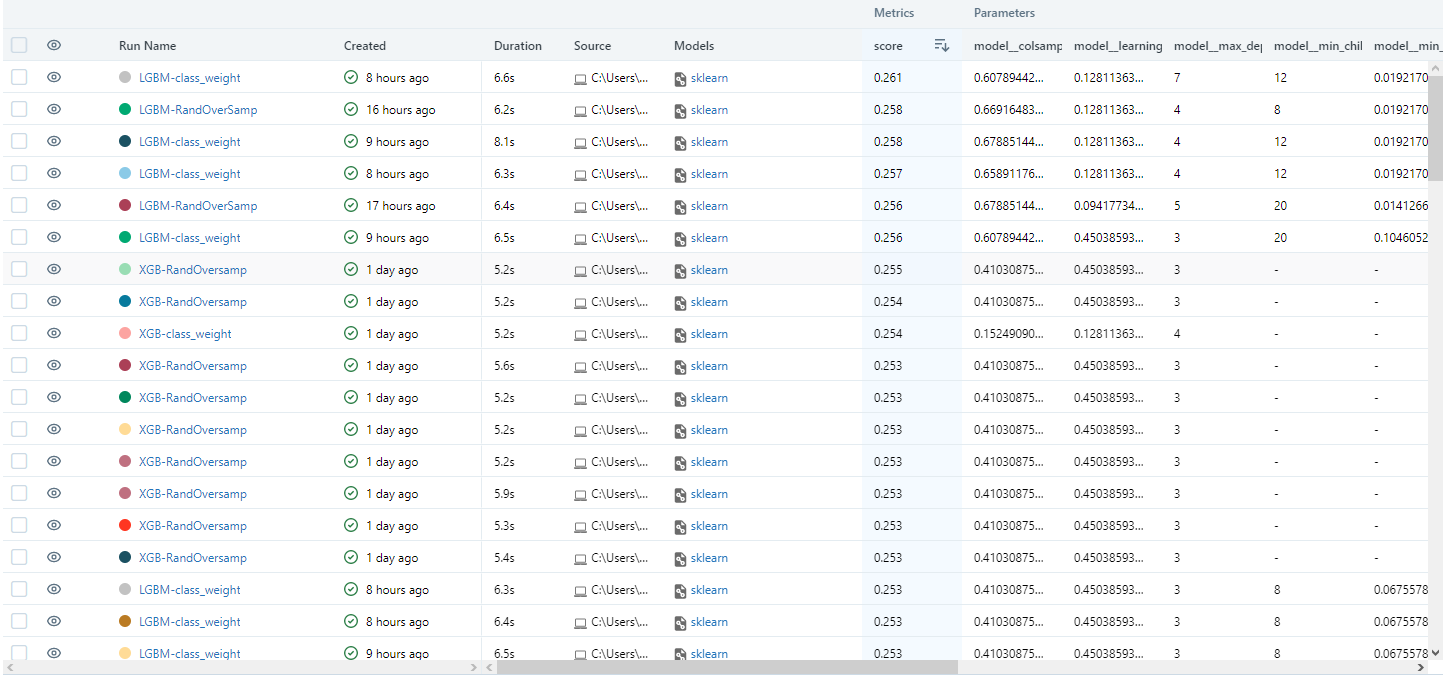

Dans cette partie, Nous allons affiner les paramètres de **LightGBM** et nous réaliserons l'équilibre des classes à l'aide de **class_weight**. En effet, c'est avec cette méthode d'équilibre de classes qu'on obtient les meilleurs scores en moyenne et les temps d'entrainement les plus faibles.

In [125]:
# estimator
model = LGBMClassifier(objective="binary", 
                       class_weight="balanced", 
                       random_state=SEED,
                       n_jobs=-1,
                       metric="None",
                       eval_metric="lgbm_eval_metric",
                       )

# pipeline for training
min_max = MinMaxScaler()
steps = [('scaler',min_max), ('model',model)]
pipe = Pipeline(steps=steps)

# splits for cross validation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

# Parameters
param_grid = {
    "model__num_leaves": Integer(22, 41, random_state=SEED),
    "model__max_depth": Integer(3, 7, random_state=SEED),
    "model__learning_rate": Continuous(0.05, 0.45, random_state=SEED),
    "model__min_split_gain": Continuous(0, 0.15, random_state=SEED),
    "model__min_child_samples": Integer(8, 32, random_state=SEED),
    "model__subsample": Continuous(0.55, 0.80, random_state=SEED),
    "model__colsample_bytree": Continuous(0.15, 0.7, random_state=SEED),
    "model__reg_lambda": Continuous(0, 2.3, random_state=SEED),
    "model__num_iterations": Integer(70, 114, random_state=SEED),
}

# Metrics
score = {"business_score": business_score, 
         "best_threshold": best_threshold,
         "business_f1_score": business_f1_score,
         "roc_auc": "roc_auc",}

# Create the MLflowConfig object and define its options
mlflow_config = MLflowConfig(
    tracking_uri="http://127.0.0.1:5000",
    experiment="FineTuning-LightGBM",
    run_name="LGBM-class_weight",
    save_models=True,
    tags={"classifier": "LightGBM Classifier", 
          "minority class oversampling": "class_weight",
         }
                            )

# Adapters to explore more diverse solutions in the first iterations
mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, 
                                      adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, 
                                       adaptive_rate=0.1)

# Callbacks
delta = DeltaThreshold(threshold=0.001, generations=5)
consecutivestopping = ConsecutiveStopping(5)
callbacks = [delta, consecutivestopping]

# GASearchCV options
evolved_estimator17 = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring=score,
    population_size=40,
    generations=30,
    tournament_size=5,
    elitism=True,
    keep_top_k=5,
    crossover_probability=crossover_adapter,
    mutation_probability=mutation_adapter,
    param_grid=param_grid,
    criteria="max",
    refit="business_score",
    error_score="raise",
    return_train_score=True,
    log_config=mlflow_config,
    n_jobs=-1,
)

evolved_estimator17.fit(X_train, y_train, callbacks=callbacks)

2023/03/30 22:12:57 INFO mlflow.tracking.fluent: Experiment with name 'FineTuning-LightGBM' does not exist. Creating a new experiment.


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	40    	0.24793	0.0082473  	0.258652   	0.228326   
1  	80    	0.256998	0.00213678 	0.259522   	0.251017   
2  	80    	0.259315	0.000944212	0.261042   	0.256859   
3  	80    	0.260205	0.000909514	0.261539   	0.25813    
4  	80    	0.260923	0.000723187	0.261987   	0.259261   
5  	80    	0.26156 	0.000405158	0.262143   	0.26064    
6  	80    	0.261798	0.000444909	0.262501   	0.260327   
7  	80    	0.262092	0.000264484	0.26268    	0.261539   
8  	80    	0.262282	0.00024171 	0.26268    	0.261987   
9  	80    	0.262604	0.000154643	0.262754   	0.262143   
10 	80    	0.262667	0.000108746	0.262754   	0.262143   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm
[LightGBM] [Warning] Unknown parameter: eval_metric


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x0000022D9077EA30>,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('model',
                                      LGBMClassifier(class_weight='balanced',
                                                     colsample_bytree=0.3938778093550321,
                                                     eval_metric='lgbm...
                       'model__subsample': <sklearn_genetic.space.space.Continuous object at 0x0000022D9078BB80>},
           population_size=40, refit='business_score', return_train_score=True,
           scoring={'best_threshold': make_scorer(threshold_optimum, needs_proba=True),
                    'business_f1_score': make_scorer(custom_f1, needs_proba=True),
                    'business_score': make_scorer(business_gain, needs_proba=True),
                    'roc_auc': 'roc_auc'},
           tournament_size=5)

In [134]:
resultize(evolved_estimator17, "rank_test_business_score").head()

,param_model__num_leaves,param_model__max_depth,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,param_model__colsample_bytree,param_model__reg_lambda,param_model__num_iterations,mean_test_business_score,std_test_business_score,rank_test_business_score,mean_train_business_score,std_train_business_score,rank_train_business_score,mean_test_best_threshold,std_test_best_threshold,rank_test_best_threshold,mean_train_best_threshold,std_train_best_threshold,rank_train_best_threshold,mean_test_business_f1_score,std_test_business_f1_score,rank_test_business_f1_score,mean_train_business_f1_score,std_train_business_f1_score,rank_train_business_f1_score,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,rank_train_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,37,7,0.140895,25,0.660854,0.393878,0.699085,101,0.262754,0.005980,1,0.371115,0.002068,352,0.658,0.009798,490,0.628,0.007483,508,0.332741,0.004720,1,0.405158,0.002532,382,0.782030,0.003612,94,0.858049,0.000798,345,61.362266,6.892994,4.771862,0.378482,"{'model__num_leaves': 37, 'model__max_depth': ..."
1,37,7,0.140895,25,0.660854,0.393878,0.699085,101,0.262754,0.005980,1,0.371115,0.002068,352,0.658,0.009798,490,0.628,0.007483,508,0.332741,0.004720,1,0.405158,0.002532,382,0.782030,0.003612,95,0.858049,0.000798,345,60.857992,6.756275,4.209835,0.247403,"{'model__num_leaves': 37, 'model__max_depth': ..."
2,37,7,0.140895,25,0.660854,0.393878,0.699085,101,0.262754,0.005980,1,0.371115,0.002068,352,0.658,0.009798,490,0.628,0.007483,508,0.332741,0.004720,1,0.405158,0.002532,382,0.782030,0.003612,93,0.858049,0.000798,345,65.033969,0.597731,4.215978,0.282273,"{'model__num_leaves': 37, 'model__max_depth': ..."
3,37,7,0.140895,25,0.660854,0.393878,0.699085,101,0.262721,0.006037,4,0.371768,0.002857,337,0.658,0.009798,490,0.628,0.007483,508,0.332716,0.004765,4,0.405586,0.002960,365,0.782015,0.003635,101,0.858086,0.000843,337,65.242980,0.709140,4.246894,0.174670,"{'model__num_leaves': 37, 'model__max_depth': ..."
4,37,7,0.140895,25,0.660854,0.393878,0.699085,101,0.262721,0.006037,4,0.371768,0.002857,337,0.658,0.009798,490,0.628,0.007483,508,0.332716,0.004765,4,0.405586,0.002960,365,0.782015,0.003635,99,0.858086,0.000843,337,64.155708,0.850703,4.229458,0.219623,"{'model__num_leaves': 37, 'model__max_depth': ..."


# 5 - Entrainement final du modèle.

In [137]:
evolved_estimator17.best_params_

{'model__num_leaves': 37,
 'model__max_depth': 7,
 'model__learning_rate': 0.14089548871391078,
 'model__min_split_gain': 0.03218770092292938,
 'model__min_child_samples': 25,
 'model__subsample': 0.6608535497068329,
 'model__colsample_bytree': 0.3938778093550321,
 'model__reg_lambda': 0.699085225544008,
 'model__num_iterations': 101}

Enregistrons les meilleurs pramètres du modèle

In [138]:
params = {
     'num_leaves': 37,
     'max_depth': 7,
     'learning_rate': 0.14089548871391078,
     'min_split_gain': 0.03218770092292938,
     'min_child_samples': 25,
     'subsample': 0.6608535497068329,
     'colsample_bytree': 0.3938778093550321,
     'reg_lambda': 0.699085225544008,
     'num_iterations': 101
}

Le seuil avec lequel on obtient le score le plus élevé est **0.658**.

In [139]:
threshold = 0.658

Nous allons maintenant entrainer le modèle sur la totalité du jeu d'entrainement et le sauvegarder sur **MLflow**.

In [180]:
final_run = MLflow_log(
    experiment = "Final_training_LGBM",
    run_name = "LGBM_final",
    library = LibraryOptions.lightgbm,
)

In [183]:
model = LGBMClassifier(
    objective="binary", 
    class_weight="balanced", 
    random_state=SEED,
    n_jobs=-1,
    metric="None",
    eval_metric="lgbm_eval_metric",
    **params,
)

# Lignes 
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

final_run.create_run(
    model_name = "best_model",
    model = model,
    x_train = X_train,
    x_test = X_test, 
    y_train = y_train, 
    y_test = y_test,
    parameters = params,
    threshold = threshold
)

Au final, le business score du modèle sur le jeu de test est **0.266**. l'AUC est de **0.785**. Le reste des métriques est disponible sur MLflow.
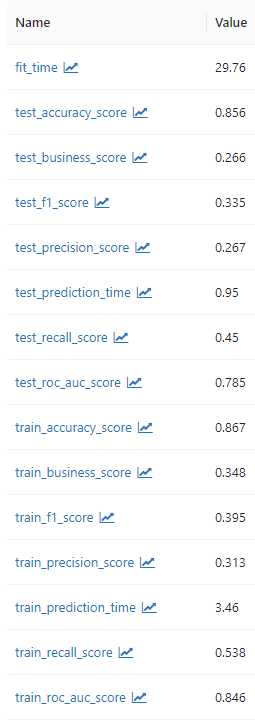

In [184]:
final_run.score

0.26623526777111345

# 6 - Feature d'importance globale et locale
## 6.1 - Globale

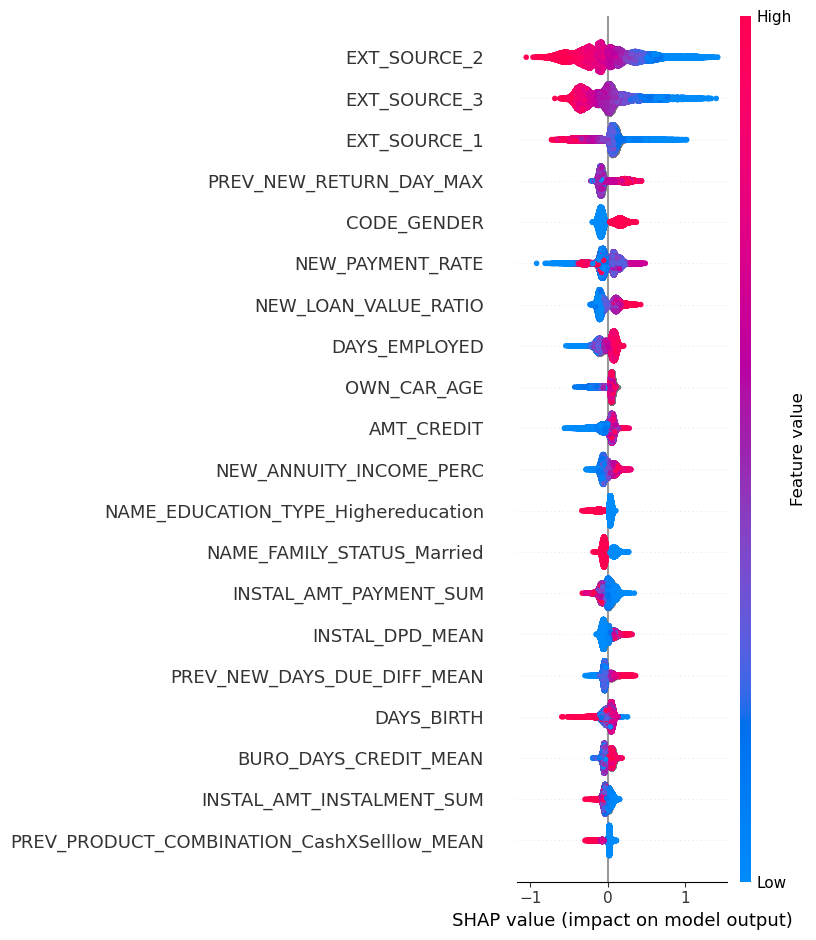

In [401]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot summary_plot
plt.clf()
shap.summary_plot(shap_values[1], X_test)

On peut voir sur le graphe ci-dessus que les 3 features les plus importantes pour la prédiction de la probabilité de remsboursement sont **EXT_SOURCE**. Plus leurs valeurs sont élevées, plus on a de chance (en moyenne) de voir sa demande de crédit acceptée.

Pour rappel, Shap retourne dans notre cas des **log odds**, et plus cette valeur est forte, plus il y'a de chance que ce client fasse défaut de paiement.

## 6.2 - Locale

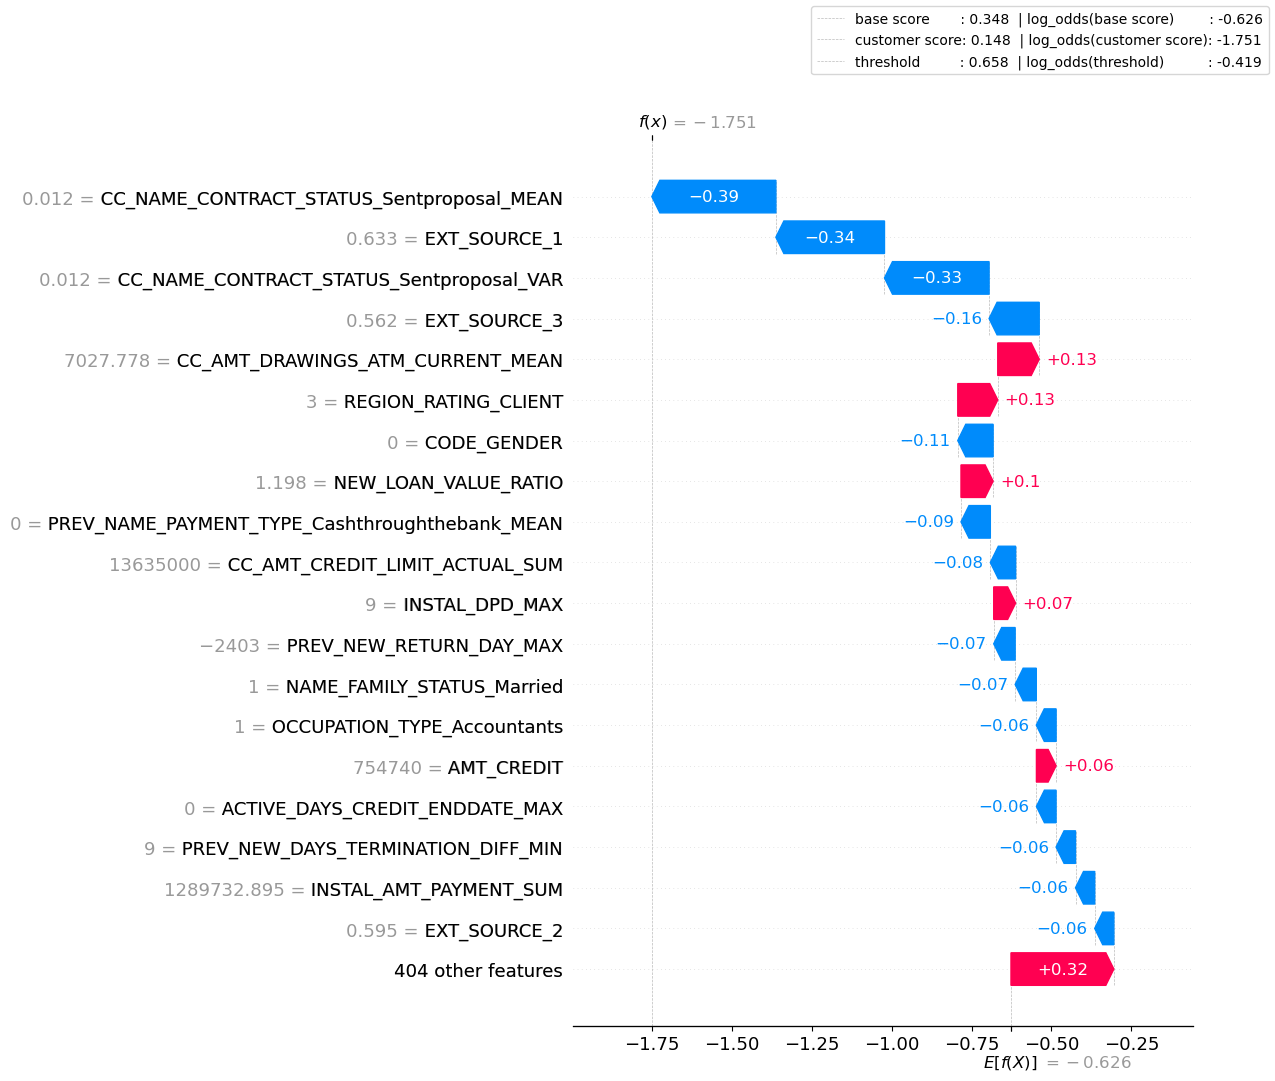

In [406]:
sample_idx = 413148

# Shap values of the customer
shap_values_loc = explainer(X_test.loc[sample_idx,:].to_numpy().reshape(1,-1))

# Feature names
shap_values_loc.feature_names = X_test.columns.tolist()

raw_base_score = explainer.expected_value[1]
raw_customer_score = explainer.expected_value[1] + shap_values_loc.values[:,:,1].sum()

# Clear the current figure
plt.clf()

# Waterfall plot of the shap values
fig = shap.waterfall_plot(shap_values_loc[0,:,1], max_display=20, show=False)

# Add the legend
fig.legend([
    f"base score       : {log_odds_to_proba(raw_base_score):.3f}  | log_odds(base score)        : {raw_base_score:.3f}", 
    f"customer score: {log_odds_to_proba(raw_customer_score):.3f}  | log_odds(customer score): {raw_customer_score:.3f}",
    f"threshold         : {threshold:.3f}  | log_odds(threshold)          : {np.log(threshold):.3f}",
           ])

# Display the plot
fig

# 7 - Sauvegarde des résultats
#### Shap values of the test set

In [414]:
global_shap_values = pd.DataFrame(data=shap_values[1], 
                                  index=X_test.index, 
                                  columns=X_test.columns)
global_shap_values.to_csv("./data/shap_values.csv")

#### Test set

In [427]:
preds = model.predict_proba(X_test)
X_test["SCORE"] = preds[:,1]
X_test.to_csv("./data/customers_data.csv")

In [428]:
X_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_PAYMENT_RATE,NEW_LOAN_VALUE_RATIO,NEW_INCOME_PER_PERSON_PERC_AMT_ANNUITY,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,NEW_FLAG_CREDIT_MORE_THAN_GOODSPRICE,NEW_AGE_RANGE,NEW_WORKING_YEAR_RANGE,NEW_TOTAL_CONTACT_INFORMATION,NEW_YEAR_LAST_PHONE_CHANGE,NEW_MISS_DOCUMENTS_20,NEW_FLAG_MISS_DOCUMENTS,NEW_AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,OCCUPATION_TYPE_nan,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_BB_MONTHS_BALANCE_MIN_MIN,BURO_BB_MONTHS_BALANCE_MAX_MAX,BURO_BB_MONTHS_BALANCE_SIZE_MEAN,BURO_BB_MONTHS_BALANCE_SIZE_SUM,BURO_NEW_BUREAU_LOAN_COUNT_MEAN,BURO_NEW_BUREAU_LOAN_TYPES_MEAN,BURO_NEW_ACTIVE_LOANS_PERCENTAGE_MAX,BURO_NEW_ACTIVE_LOANS_PERCENTAGE_MEAN,BURO_NEW_CREDIT_ENDDATE_PERCENTAGE_MAX,BURO_NEW_CREDIT_ENDDATE_PERCENTAGE_MEAN,BURO_NEW_DEBT_CREDIT_RATIO_MAX,BURO_NEW_DEBT_CREDIT_RATIO_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Rare_MEAN,BURO_CREDIT_CURRENCY_Rare_MEAN,BURO_CREDIT_CURRENCY_currency1_MEAN,BURO_CREDIT_TYPE_Carloan_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Rare_MEAN,BURO_BB_STATUS_0_MEAN_MEAN,BURO_BB_STATUS_1_MEAN_MEAN,BURO_BB_STATUS_2_MEAN_MEAN,BURO_BB_STATUS_3_MEAN_MEAN,BURO_BB_STATUS_4_MEAN_MEAN,BURO_BB_STATUS_5_MEAN_MEAN,BURO_BB_STATUS_C_MEAN_MEAN,BURO_BB_STATUS_X_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_